## Project overview

## Necessary Libraries/Modules for Modeling & Forecasting 

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Import Data from yfinance
- comparison between NVDA and ARM (using softbank as proxy bc they own arm before ipo in 2023)
- AMD and INTEL are Exogenous Variables 

In [2]:
data = yfinance.download (tickers = "NVDA, SFTBY, AMD, INTC", interval = "1d", group_by = 'ticker',
                              auto_adjust = True, threads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df = data.copy()

Key Dates for the Deal
- NVDIA announces intent to acquire ARM
- first announcement: Regulatory concerns leads to security investigation
- second announcement: FTC files lawsuit to block acquisition
- scandal: deal terminated

In [4]:
start = '2020-09-13'
end = '2022-02-14'
announcement_1 = '2021-07-20'
announcement_2 = '2021-12-02'
scandal = '2022-02-07'

In [5]:
df.describe()

Ticker           AMD                                                          \
Price           Open          High           Low         Close        Volume   
count   11421.000000  11421.000000  11421.000000  11421.000000  1.142100e+04   
mean       22.033726     22.778620     21.841654     22.310963  1.992711e+07   
std        33.789033     34.251873     32.926776     33.588953  2.875238e+07   
min         0.000000      1.690000      1.610000      1.620000  0.000000e+00   
25%         5.230000      5.687500      5.380000      5.541667  1.344600e+06   
50%        10.437500     10.625000     10.150000     10.375000  7.794100e+06   
75%        17.437500     17.700001     17.125000     17.379999  2.688410e+07   
max       213.410004    227.300003    208.220001    211.380005  3.250584e+08   

Ticker          INTC                                                          \
Price           Open          High           Low         Close        Volume   
count   11421.000000  11421.000000  11421.000000  11421.000000  1.142100e+04   
mean       15.059181     15.262458     14.857826     15.059162  5.114140e+07   
std        14.639779     14.824600     14.457987     14.641293  3.522698e+07   
min         0.121968      0.121968      0.120516      0.120516  0.000000e+00   
25%         0.827638      0.840707      0.814571      0.827638  2.767920e+07   
50%        12.918381     13.080001     12.724847     12.895621  4.489760e+07   
75%        22.580000     22.860813     22.295768     22.579071  6.514820e+07   
max        62.028756     62.292516     60.600826     62.083336  5.677088e+08   

Ticker         NVDA                                                       \
Price          Open         High          Low        Close        Volume   
count   6656.000000  6656.000000  6656.000000  6656.000000  6.656000e+03   
mean      10.492021    10.684610    10.282918    10.493862  5.940441e+08   
std       27.701955    28.194977    27.144051    27.694907  4.297038e+08   
min        0.031997     0.032594     0.030564     0.031281  1.968000e+07   
25%        0.259493     0.267266     0.252158     0.260016  3.316485e+08   
50%        0.441667     0.447797     0.435272     0.441634  4.953635e+08   
75%        5.006335     5.100714     4.861647     5.030383  7.254630e+08   
max      161.220001   164.419998   161.160004   162.880005  9.230856e+09   

Ticker        SFTBY                                                       
Price          Open         High          Low        Close        Volume  
count   3619.000000  3619.000000  3619.000000  3619.000000  3.619000e+03  
mean      19.977680    20.191028    19.778265    19.992698  5.059961e+05  
std        7.937465     8.033576     7.821402     7.928726  6.642942e+05  
min        6.705000     6.735000     6.705000     6.720000  0.000000e+00  
25%       14.727500    14.795000    14.605000    14.685000  1.605000e+05  
50%       19.520000    19.719999    19.350000    19.549999  3.448000e+05  
75%       23.600000    23.915000    23.330000    23.645000  6.222000e+05  
max       49.419998    50.000000    49.400002    49.500000  1.720900e+07

In [6]:
df = df.asfreq('b')
df = df.bfill()

Next, create Columns within the DataFrame and extract closing price, use that to create columns for returns, log returns, squared returns, squared log returns and Volume

Then, fill the missing values in the dataset and delete the unneccessary collumns

In [7]:
df['NVDA_close'] = df['NVDA']['Close']
df['SFTBY_close'] = df['SFTBY']['Close']
df['AMD_close'] = df['AMD']['Close']
df['INTC_close'] = df['INTC']['Close']

df['NVDA_returns'] = df['NVDA_close'].pct_change(1).mul(100)
df['SFTBY_returns'] = df['SFTBY_close'].pct_change(1).mul(100)
df['AMD_returns'] = df['AMD_close'].pct_change(1).mul(100)
df['INTC_returns'] = df['INTC_close'].pct_change(1).mul(100)

df['NVDA_sq_returns'] = df['NVDA_returns'] ** 2
df['SFTBY_sq_returns'] = df['SFTBY_returns'] ** 2
df['AMD_sq_returns'] = df['AMD_returns'] ** 2
df['INTC_sq_returns'] = df['INTC_returns'] ** 2

df['NVDA_volume'] = df['NVDA']['Volume']
df['SFTBY_volume'] = df['SFTBY']['Volume']
df['AMD_volume'] = df['AMD']['Volume']
df['INTC_volume'] = df['INTC']['Volume']

df['NVDA_log_returns'] = np.log(1 + df['NVDA_close'].pct_change())
df['SFTBY_log_returns'] = np.log(1 + df['SFTBY_close'].pct_change())
df['AMD_log_returns'] = np.log(1 + df['AMD_close'].pct_change())
df['INTC_log_returns'] = np.log(1 + df['INTC_close'].pct_change())

df['NVDA_sq_log_returns'] = df['NVDA_log_returns'] ** 2
df['SFTBY_sq_log_returns'] = df['SFTBY_log_returns'] ** 2
df['AMD_sq_log_returns'] = df['AMD_log_returns'] ** 2
df['INTC_sq_log_returns'] = df['INTC_log_returns'] ** 2

1st Stage is complete (NOTE: Looking into specific event, therefore no need to split data for training/testing)

Next, we will plot the the newly created columns of data and run some tests

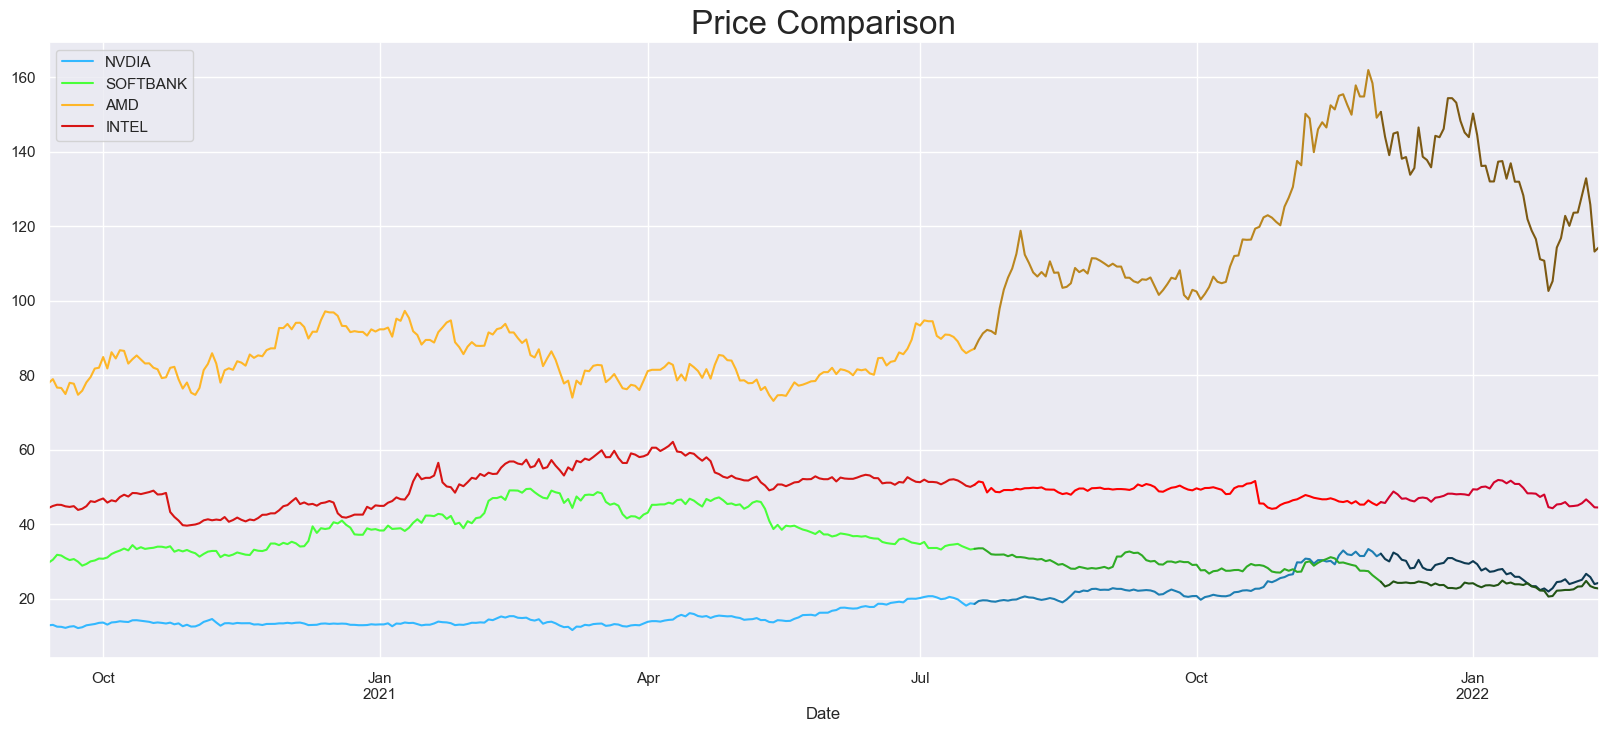

In [8]:
df['NVDA_close'][start:announcement_1].plot(figsize= (20,8), color = "#33B8FF")
df['SFTBY_close'][start:announcement_1].plot(color = "#49FF3A")
df['AMD_close'][start:announcement_1].plot(color = "#FEB628")
df['INTC_close'][start:announcement_1].plot(color = "#D71515")

df['NVDA_close'][announcement_1:announcement_2].plot(color = "#1E7EB2")
df['SFTBY_close'][announcement_1:announcement_2].plot(color = "#2FAB25")
df['AMD_close'][announcement_1:announcement_2].plot(color = "#BA861F")
df['INTC_close'][announcement_1:announcement_2].plot(color = "red")

df['NVDA_close'][announcement_2:end].plot(color = "#0E3A52")
df['SFTBY_close'][announcement_2:end].plot(color = "#225414")
df['AMD_close'][announcement_2:end].plot(color = "#7C5913")
df['INTC_close'][announcement_2:end].plot(color = "#D2042D")

plt.legend(['NVDIA','SOFTBANK','AMD','INTEL'])
plt.title("Price Comparison", size = 24)
plt.show()

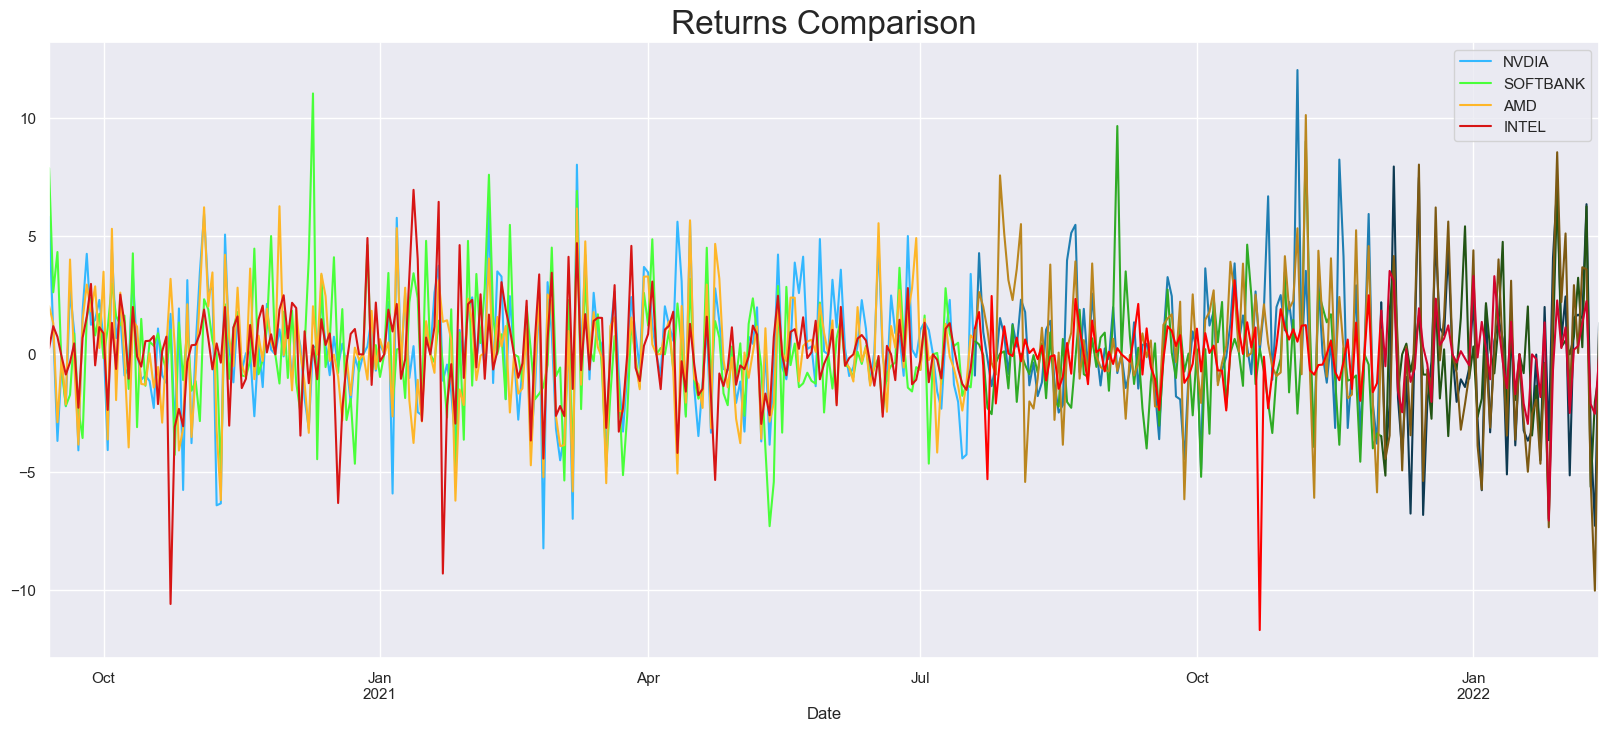

In [9]:
df['NVDA_returns'][start:announcement_1].plot(figsize= (20,8), color = "#33B8FF")
df['SFTBY_returns'][start:announcement_1].plot(color = "#49FF3A")
df['AMD_returns'][start:announcement_1].plot(color = "#FEB628")
df['INTC_returns'][start:announcement_1].plot(color = "#D71515")

df['NVDA_returns'][announcement_1:announcement_2].plot(color = "#1E7EB2")
df['SFTBY_returns'][announcement_1:announcement_2].plot(color = "#2FAB25")
df['AMD_returns'][announcement_1:announcement_2].plot(color = "#BA861F")
df['INTC_returns'][announcement_1:announcement_2].plot(color = "red")

df['NVDA_returns'][announcement_2:end].plot(color = "#0E3A52")
df['SFTBY_returns'][announcement_2:end].plot(color = "#225414")
df['AMD_returns'][announcement_2:end].plot(color = "#7C5913")
df['INTC_returns'][announcement_2:end].plot(color = "#D2042D")

plt.legend(['NVDIA','SOFTBANK','AMD','INTEL'])
plt.title("Returns Comparison", size = 24)
plt.show()

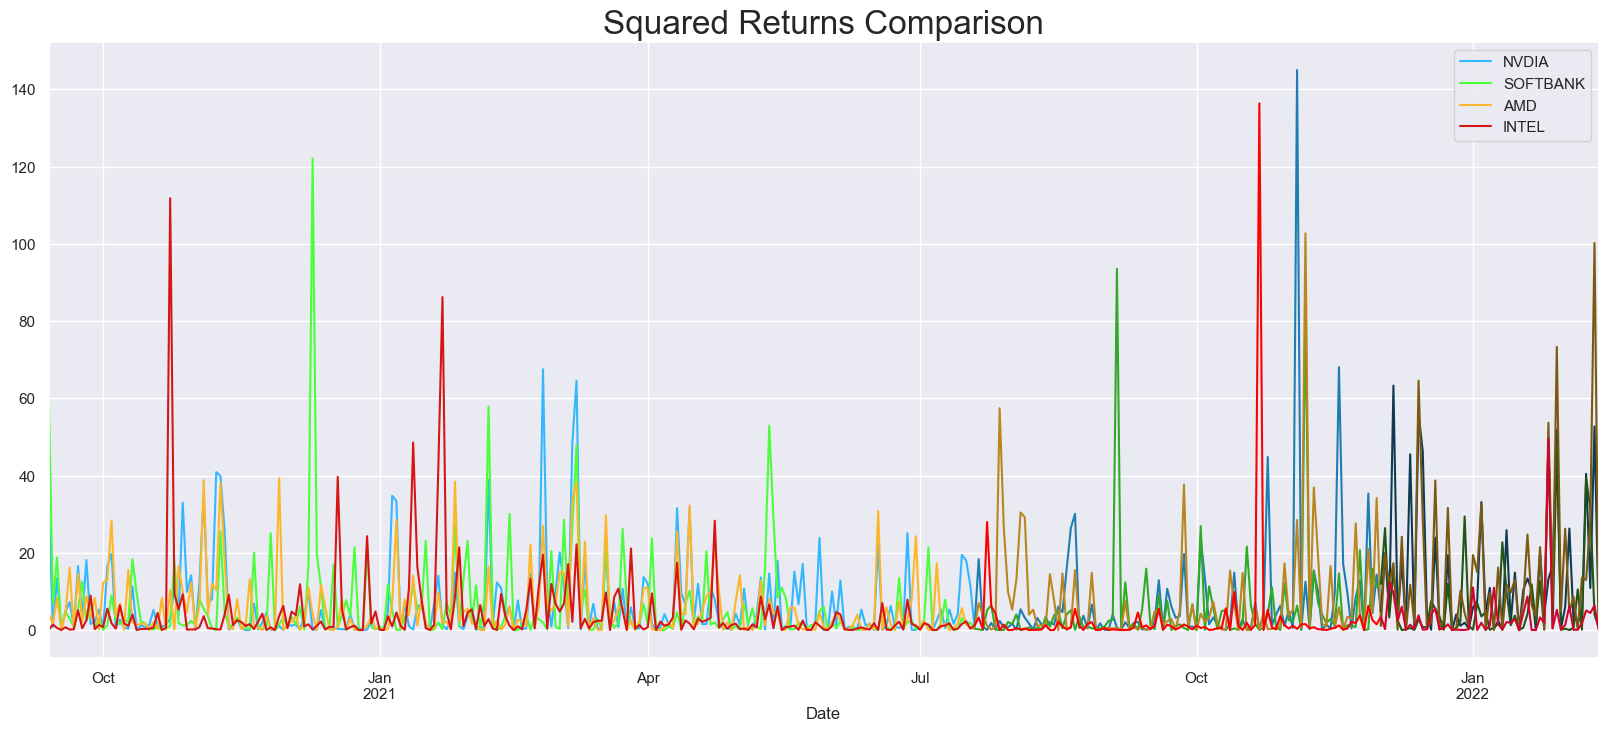

In [10]:
df['NVDA_sq_returns'][start:announcement_1].plot(figsize= (20,8), color = "#33B8FF")
df['SFTBY_sq_returns'][start:announcement_1].plot(color = "#49FF3A")
df['AMD_sq_returns'][start:announcement_1].plot(color = "#FEB628")
df['INTC_sq_returns'][start:announcement_1].plot(color = "#D71515")

df['NVDA_sq_returns'][announcement_1:announcement_2].plot(color = "#1E7EB2")
df['SFTBY_sq_returns'][announcement_1:announcement_2].plot(color = "#2FAB25")
df['AMD_sq_returns'][announcement_1:announcement_2].plot(color = "#BA861F")
df['INTC_sq_returns'][announcement_1:announcement_2].plot(color = "red")

df['NVDA_sq_returns'][announcement_2:end].plot(color = "#0E3A52")
df['SFTBY_sq_returns'][announcement_2:end].plot(color = "#225414")
df['AMD_sq_returns'][announcement_2:end].plot(color = "#7C5913")
df['INTC_sq_returns'][announcement_2:end].plot(color = "#D2042D")

plt.legend(['NVDIA','SOFTBANK','AMD','INTEL'])
plt.title("Squared Returns Comparison", size = 24)
plt.show()

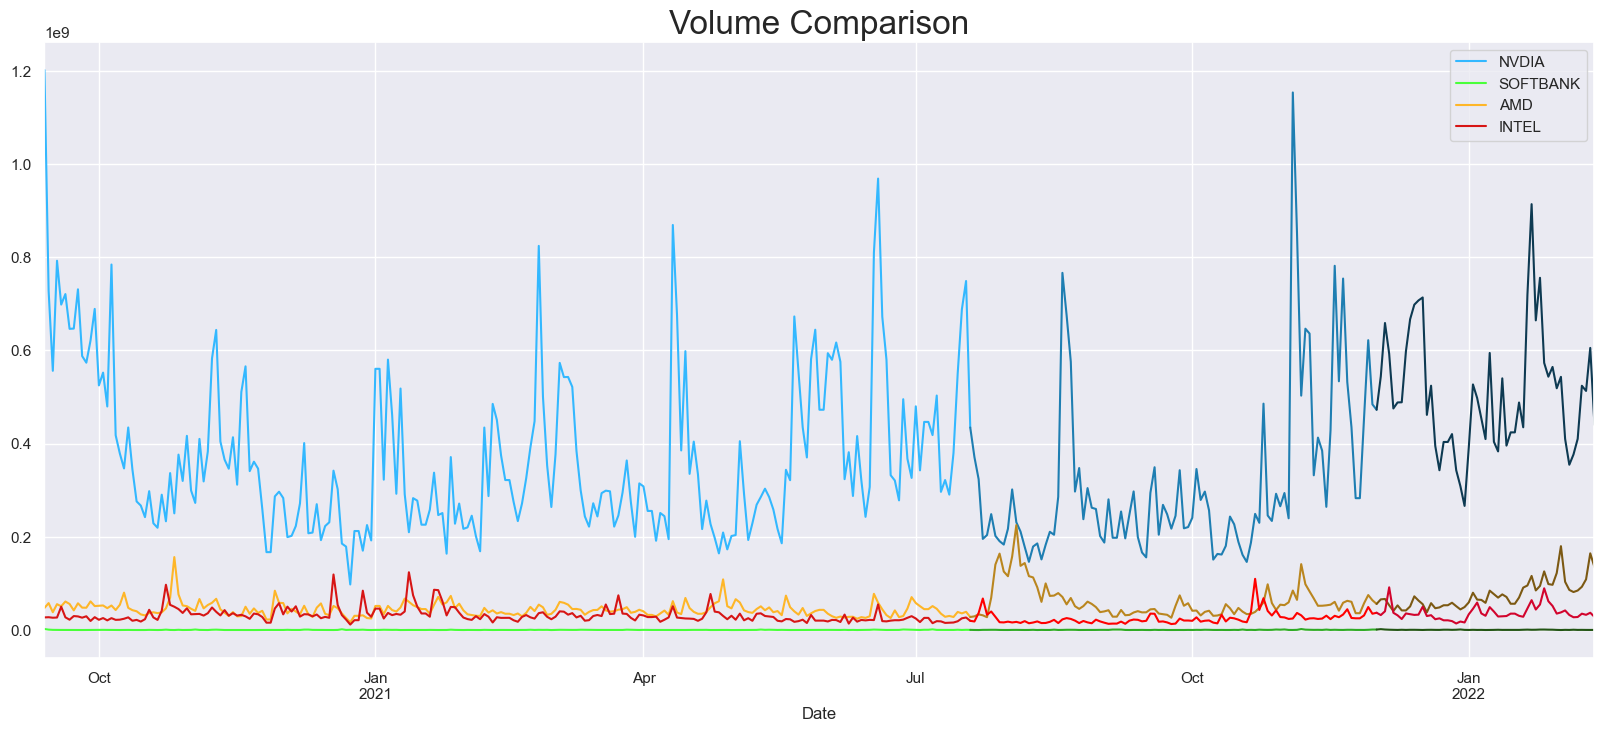

In [11]:
df['NVDA_volume'][start:announcement_1].plot(figsize= (20,8), color = "#33B8FF")
df['SFTBY_volume'][start:announcement_1].plot(color = "#49FF3A")
df['AMD_volume'][start:announcement_1].plot(color = "#FEB628")
df['INTC_volume'][start:announcement_1].plot(color = "#D71515")

df['NVDA_volume'][announcement_1:announcement_2].plot(color = "#1E7EB2")
df['SFTBY_volume'][announcement_1:announcement_2].plot(color = "#2FAB25")
df['AMD_volume'][announcement_1:announcement_2].plot(color = "#BA861F")
df['INTC_volume'][announcement_1:announcement_2].plot(color = "red")

df['NVDA_volume'][announcement_2:end].plot(color = "#0E3A52")
df['SFTBY_volume'][announcement_2:end].plot(color = "#225414")
df['AMD_volume'][announcement_2:end].plot(color = "#7C5913")
df['INTC_volume'][announcement_2:end].plot(color = "#D2042D")

plt.legend(['NVDIA','SOFTBANK','AMD','INTEL'])
plt.title("Volume Comparison", size = 24)
plt.show()

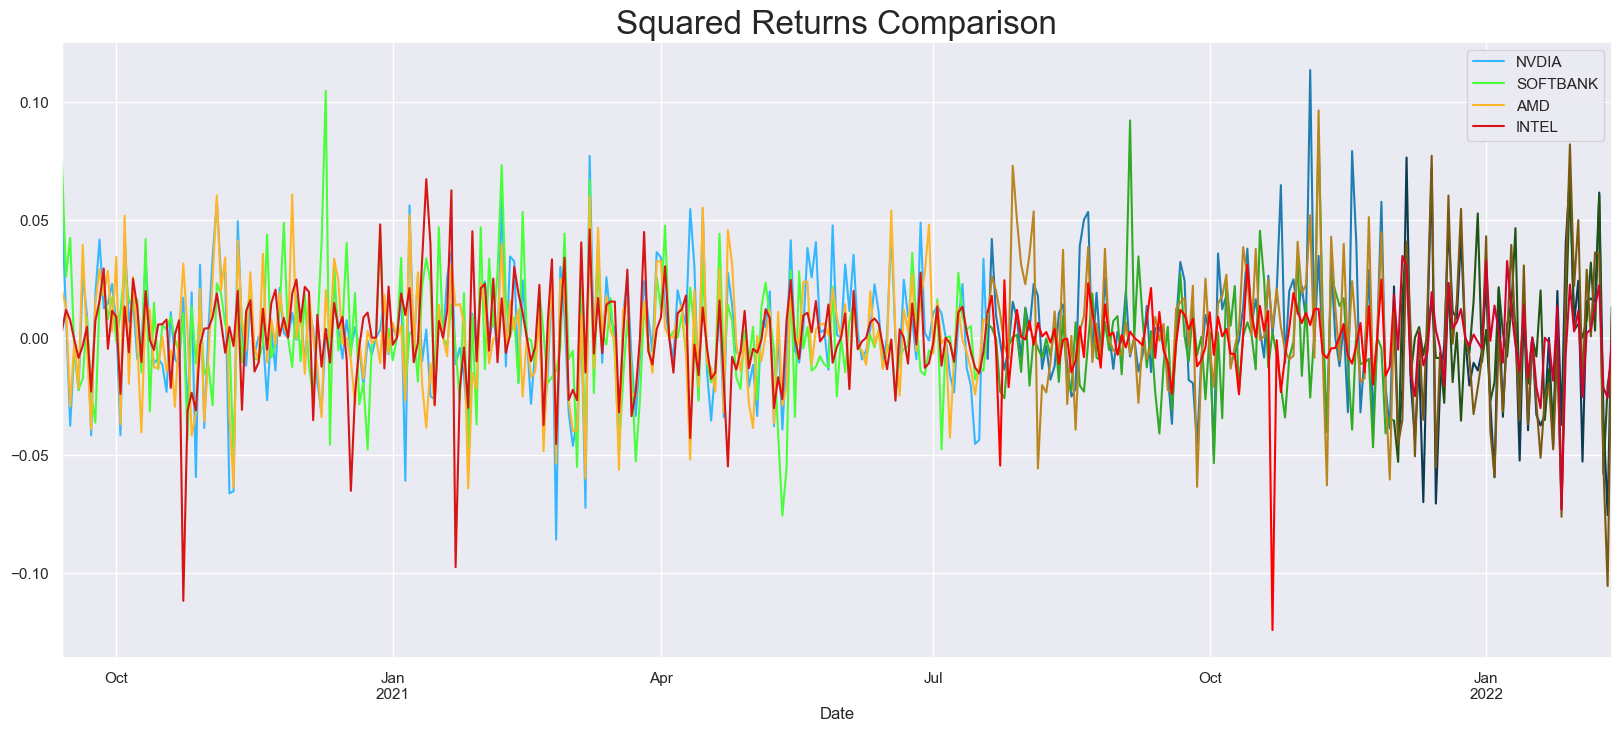

In [12]:
df['NVDA_log_returns'][start:announcement_1].plot(figsize= (20,8), color = "#33B8FF")
df['SFTBY_log_returns'][start:announcement_1].plot(color = "#49FF3A")
df['AMD_log_returns'][start:announcement_1].plot(color = "#FEB628")
df['INTC_log_returns'][start:announcement_1].plot(color = "#D71515")

df['NVDA_log_returns'][announcement_1:announcement_2].plot(color = "#1E7EB2")
df['SFTBY_log_returns'][announcement_1:announcement_2].plot(color = "#2FAB25")
df['AMD_log_returns'][announcement_1:announcement_2].plot(color = "#BA861F")
df['INTC_log_returns'][announcement_1:announcement_2].plot(color = "red")

df['NVDA_log_returns'][announcement_2:end].plot(color = "#0E3A52")
df['SFTBY_log_returns'][announcement_2:end].plot(color = "#225414")
df['AMD_log_returns'][announcement_2:end].plot(color = "#7C5913")
df['INTC_log_returns'][announcement_2:end].plot(color = "#D2042D")

plt.legend(['NVDIA','SOFTBANK','AMD','INTEL'])
plt.title("Squared Returns Comparison", size = 24)
plt.show()

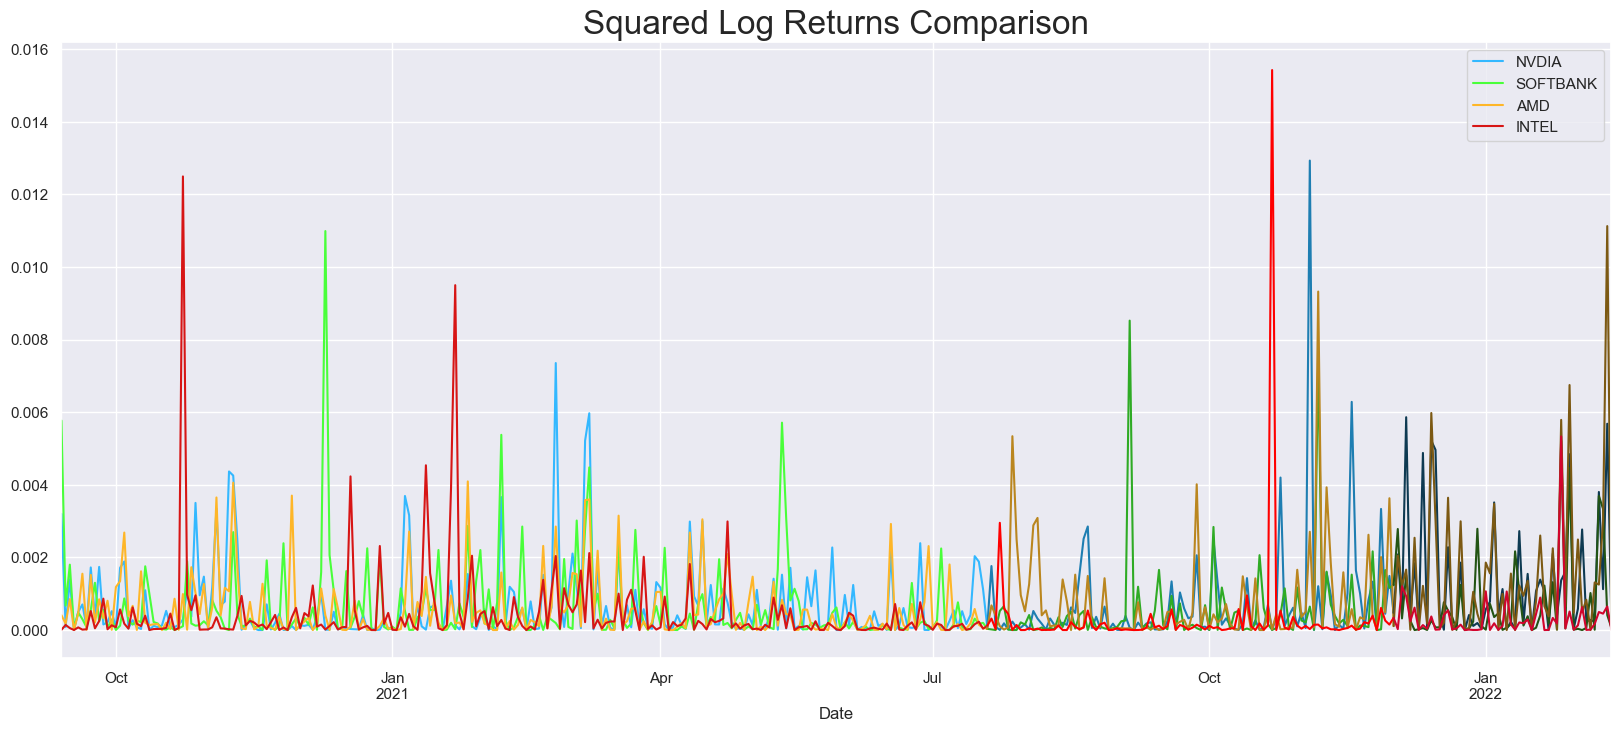

In [13]:
df['NVDA_sq_log_returns'][start:announcement_1].plot(figsize= (20,8), color = "#33B8FF")
df['SFTBY_sq_log_returns'][start:announcement_1].plot(color = "#49FF3A")
df['AMD_sq_log_returns'][start:announcement_1].plot(color = "#FEB628")
df['INTC_sq_log_returns'][start:announcement_1].plot(color = "#D71515")

df['NVDA_sq_log_returns'][announcement_1:announcement_2].plot(color = "#1E7EB2")
df['SFTBY_sq_log_returns'][announcement_1:announcement_2].plot(color = "#2FAB25")
df['AMD_sq_log_returns'][announcement_1:announcement_2].plot(color = "#BA861F")
df['INTC_sq_log_returns'][announcement_1:announcement_2].plot(color = "red")

df['NVDA_sq_log_returns'][announcement_2:end].plot(color = "#0E3A52")
df['SFTBY_sq_log_returns'][announcement_2:end].plot(color = "#225414")
df['AMD_sq_log_returns'][announcement_2:end].plot(color = "#7C5913")
df['INTC_sq_log_returns'][announcement_2:end].plot(color = "#D2042D")

plt.legend(['NVDIA','SOFTBANK','AMD','INTEL'])
plt.title("Squared Log Returns Comparison", size = 24)
plt.show()

Next, let's take a look into the correlation between the Companies during the different periods

In [14]:
print('Correlation From ' + str(start) + ' to ' + str(end) + '\n')
print('NVDIA and SOFTBANK(ARM) correlation: \t' + str(df['NVDA_close'][start:end].corr(df['SFTBY_close'][start:end])))
print('NVDIA and AMD correlation: \t' + str(df['NVDA_close'][start:end].corr(df['AMD_close'][start:end])))
print('NVDIA and INTC correlation: \t' + str(df['NVDA_close'][start:end].corr(df['INTC_close'][start:end])))
print('AMD and SOFTBANK(ARM) correlation: \t' + str(df['AMD_close'][start:end].corr(df['SFTBY_close'][start:end])))
print('INTC and SOFTBANK(ARM) correlation: \t' + str(df['INTC_close'][start:end].corr(df['SFTBY_close'][start:end])))
print('AMD and INTC correlation: \t' + str(df['AMD_close'][start:end].corr(df['INTC_close'][start:end])))

Correlation From 2020-09-13 to 2022-02-14

NVDIA and SOFTBANK(ARM) correlation: 	-0.721442677255998
NVDIA and AMD correlation: 	0.9390402670511377
NVDIA and INTC correlation: 	-0.17396851263206475
AMD and SOFTBANK(ARM) correlation: 	-0.6902833104607332
INTC and SOFTBANK(ARM) correlation: 	0.6183852550657198
AMD and INTC correlation: 	-0.27112739312882156


In [15]:
print('Correlation From ' + str(start) + ' to ' + str(announcement_1) + '\n')
print('NVDIA and SOFTBANK(ARM) correlation: \t' + str(df['NVDA_close'][start:announcement_1].corr(df['SFTBY_close'][start:announcement_1])))
print('NVDIA and AMD correlation: \t' + str(df['NVDA_close'][start:announcement_1].corr(df['AMD_close'][start:announcement_1])))
print('NVDIA and INTC correlation: \t' + str(df['NVDA_close'][start:announcement_1].corr(df['INTC_close'][start:announcement_1])))
print('AMD and SOFTBANK(ARM) correlation: \t' + str(df['AMD_close'][start:announcement_1].corr(df['SFTBY_close'][start:announcement_1])))
print('INTC and SOFTBANK(ARM) correlation: \t' + str(df['INTC_close'][start:announcement_1].corr(df['SFTBY_close'][start:announcement_1])))
print('AMD and INTC correlation: \t' + str(df['AMD_close'][start:announcement_1].corr(df['INTC_close'][start:announcement_1])))

Correlation From 2020-09-13 to 2021-07-20

NVDIA and SOFTBANK(ARM) correlation: 	-0.11047708128649868
NVDIA and AMD correlation: 	0.16771725866319323
NVDIA and INTC correlation: 	0.2599503271861232
AMD and SOFTBANK(ARM) correlation: 	0.01609936209293892
INTC and SOFTBANK(ARM) correlation: 	0.7683686243797518
AMD and INTC correlation: 	-0.1579137794837638


In [16]:
print('Correlation From ' + str(announcement_1) + ' to ' + str(announcement_2) + '\n')
print('NVDIA and SOFTBANK(ARM) correlation: \t' + str(df['NVDA_close'][announcement_1:announcement_2].corr(df['SFTBY_close'][announcement_1:announcement_2])))
print('NVDIA and AMD correlation: \t' + str(df['NVDA_close'][announcement_1:announcement_2].corr(df['AMD_close'][announcement_1:announcement_2])))
print('NVDIA and INTC correlation: \t' + str(df['NVDA_close'][announcement_1:announcement_2].corr(df['INTC_close'][announcement_1:announcement_2])))
print('AMD and SOFTBANK(ARM) correlation: \t' + str(df['AMD_close'][announcement_1:announcement_2].corr(df['SFTBY_close'][announcement_1:announcement_2])))
print('INTC and SOFTBANK(ARM) correlation: \t' + str(df['INTC_close'][announcement_1:announcement_2].corr(df['SFTBY_close'][announcement_1:announcement_2])))
print('AMD and INTC correlation: \t' + str(df['AMD_close'][announcement_1:announcement_2].corr(df['INTC_close'][announcement_1:announcement_2])))

Correlation From 2021-07-20 to 2021-12-02

NVDIA and SOFTBANK(ARM) correlation: 	-0.3736363145710004
NVDIA and AMD correlation: 	0.9644890665713
NVDIA and INTC correlation: 	-0.7227006528655813
AMD and SOFTBANK(ARM) correlation: 	-0.38474277915601873
INTC and SOFTBANK(ARM) correlation: 	0.45090028835069035
AMD and INTC correlation: 	-0.7301767335282401


In [17]:
print('Correlation From ' + str(announcement_2) + ' to ' + str(end) + '\n')
print('NVDIA and SOFTBANK(ARM) correlation: \t' + str(df['NVDA_close'][announcement_2:end].corr(df['SFTBY_close'][announcement_2:end])))
print('NVDIA and AMD correlation: \t' + str(df['NVDA_close'][announcement_2:end].corr(df['AMD_close'][announcement_2:end])))
print('NVDIA and INTC correlation: \t' + str(df['NVDA_close'][announcement_2:end].corr(df['INTC_close'][announcement_2:end])))
print('AMD and SOFTBANK(ARM) correlation: \t' + str(df['AMD_close'][announcement_2:end].corr(df['SFTBY_close'][announcement_2:end])))
print('INTC and SOFTBANK(ARM) correlation: \t' + str(df['INTC_close'][announcement_2:end].corr(df['SFTBY_close'][announcement_2:end])))
print('AMD and INTC correlation: \t' + str(df['AMD_close'][announcement_2:end].corr(df['INTC_close'][announcement_2:end])))

Correlation From 2021-12-02 to 2022-02-14

NVDIA and SOFTBANK(ARM) correlation: 	0.6195095150588286
NVDIA and AMD correlation: 	0.9428100045239
NVDIA and INTC correlation: 	0.2568437018571403
AMD and SOFTBANK(ARM) correlation: 	0.6463381024971876
INTC and SOFTBANK(ARM) correlation: 	0.45071040162650755
AMD and INTC correlation: 	0.3862956325290991


In [18]:
print('Correlation From ' + str(end) + ' to ' + str(df.index[-1]) + '\n')
print('NVDIA and SOFTBANK(ARM) correlation: \t' + str(df['NVDA_close'][end:].corr(df['SFTBY_close'][end:])))
print('NVDIA and AMD correlation: \t' + str(df['NVDA_close'][end:].corr(df['AMD_close'][end:])))
print('NVDIA and INTC correlation: \t' + str(df['NVDA_close'][end:].corr(df['INTC_close'][end:])))
print('AMD and SOFTBANK(ARM) correlation: \t' + str(df['AMD_close'][end:].corr(df['SFTBY_close'][end:])))
print('INTC and SOFTBANK(ARM) correlation: \t' + str(df['INTC_close'][end:].corr(df['SFTBY_close'][end:])))
print('AMD and INTC correlation: \t' + str(df['AMD_close'][end:].corr(df['INTC_close'][end:])))

Correlation From 2022-02-14 to 2025-07-09 00:00:00

NVDIA and SOFTBANK(ARM) correlation: 	0.8826727918572651
NVDIA and AMD correlation: 	0.6321669988932533
NVDIA and INTC correlation: 	-0.5092407284463822
AMD and SOFTBANK(ARM) correlation: 	0.6719103998081342
INTC and SOFTBANK(ARM) correlation: 	-0.3632545183623722
AMD and INTC correlation: 	0.19654866064663767


Comments about the correlation between time periods: 


## Auto Generating Best Fitting Models

### NVDIA
- max p is given from ACF information
- max q is given by PACF information
- all others set to 5 for loose restrictions
- wait time to load (approximately): 

In [19]:
model_NVDA_close_period1 = auto_arima(df.NVDA_close[start:announcement_1], exogenous = df[['SFTBY_close','AMD_close','INTC_close']][start:announcement_1],
                                     m = 5, max_order = None, max_p = 32, max_q = 7, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

In [20]:
model_NVDA_close_period2 = auto_arima(df.NVDA_close[announcement_1:announcement_2], exogenous = df[['SFTBY_close','AMD_close','INTC_close']][announcement_1:announcement_2],
                                     m = 5, max_order = None, max_p = 32, max_q = 7, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

In [21]:
model_NVDA_close_period3 = auto_arima(df.NVDA_close[announcement_2:end], exogenous = df[['SFTBY_close','AMD_close','INTC_close']][announcement_2:end],
                                     m = 5, max_order = None,max_p = 32, max_q = 7, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

In [22]:
model_NVDA_close_period_all = auto_arima(df.NVDA_close[start:end], exogenous = df[['SFTBY_close','AMD_close','INTC_close']][start:end],
                                     m = 5, max_order = None, max_p = 32, max_q = 7, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

In [23]:
model_NVDA_close_period1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -89.852
Date:                Wed, 09 Jul 2025   AIC                            185.703
Time:                        21:43:06   BIC                            195.898
Sample:                    09-14-2020   HQIC                           189.819
                         - 07-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0070      0.052     -0.134      0.894      -0.110       0.096
drift          0.0003      0.000      0.776      0.438      -0.000       0.001
sigma2         0.1320      0.011     11.637      0.000       0.110       0.154
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):                 4.01
Prob(Q):                              0.24   Prob(JB):                         0.13
Heteroskedasticity (H):               1.45   Skew:                            -0.20
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
model_NVDA_close_period2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -100.538
Date:                Wed, 09 Jul 2025   AIC                            207.077
Time:                        21:43:06   BIC                            214.801
Sample:                    07-20-2021   HQIC                           210.200
                         - 12-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0263      0.217      0.121      0.904      -0.399       0.452
drift          0.0023      0.003      0.794      0.427      -0.003       0.008
sigma2         0.4654      0.044     10.585      0.000       0.379       0.552
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                73.93
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               6.19   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
model_NVDA_close_period3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -73.979
Date:                Wed, 09 Jul 2025   AIC                            153.958
Time:                        21:43:06   BIC                            159.811
Sample:                    12-02-2021   HQIC                           156.202
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2556      0.249     -1.028      0.304      -0.743       0.232
drift          0.0040      0.009      0.464      0.643      -0.013       0.021
sigma2         1.0075      0.214      4.704      0.000       0.588       1.427
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.55   Prob(JB):                         0.60
Heteroskedasticity (H):               0.57   Skew:                             0.34
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
model_NVDA_close_period_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  371
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -331.834
Date:                Wed, 09 Jul 2025   AIC                            669.668
Time:                        21:43:06   BIC                            681.409
Sample:                    09-14-2020   HQIC                           674.332
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0328      0.096      0.340      0.734      -0.156       0.222
drift      -1.091e-05      0.000     -0.033      0.974      -0.001       0.001
sigma2         0.3520      0.015     23.736      0.000       0.323       0.381
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):               307.20
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               6.47   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

all price models seem to suggest a SARIMAX(0,1,0) when testing using oob and aic as the testing information criteria, this actually breaks down to an ARIMA(0,1,0) only integrating to ensure stationaity. we will analyze this further later 

next, we should analyse the log returns, we do this instead of the normal returns because they help to adjust for stationaity better whic would meet the assumptions needed for an ARIMA model

In [27]:
model_NVDA_log_returns_period1 = auto_arima(df.NVDA_log_returns[start:announcement_1], exogenous = df[['SFTBY_log_returns','AMD_log_returns','INTC_log_returns']][start:announcement_1],
                                     m = 5, max_order = None, max_p = 6, max_q = 6, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_NVDA_log_returns_period2 = auto_arima(df.NVDA_log_returns[announcement_1:announcement_2], exogenous = df[['SFTBY_log_returns','AMD_log_returns','INTC_log_returns']][announcement_1:announcement_2],
                                     m = 5, max_order = None, max_p = 6, max_q = 6, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_NVDA_log_returns_period3 = auto_arima(df.NVDA_log_returns[announcement_2:end], exogenous = df[['SFTBY_log_returns','AMD_log_returns','INTC_log_returns']][announcement_2:end],
                                     m = 5, max_order = None, max_p = 6, max_q = 6, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_NVDA_log_returns_period_all = auto_arima(df.NVDA_log_returns[start:end], exogenous = df[['SFTBY_log_returns','AMD_log_returns','INTC_log_returns']][start:end],
                                     m = 5, max_order = None, max_p = 6, max_q = 6, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

In [28]:
model_NVDA_log_returns_period1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 498.764
Date:                Wed, 09 Jul 2025   AIC                           -989.528
Time:                        21:43:10   BIC                           -975.918
Sample:                    09-14-2020   HQIC                          -984.033
                         - 07-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.003     -0.073      0.941      -0.007       0.006
drift       1.916e-05   2.72e-05      0.704      0.481   -3.42e-05    7.25e-05
ar.L1         -0.1049      0.057     -1.837      0.066      -0.217       0.007
sigma2         0.0006   5.39e-05     11.930      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.20
Prob(Q):                              0.98   Prob(JB):                         0.03
Heteroskedasticity (H):               0.88   Skew:                            -0.32
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
model_NVDA_log_returns_period2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                 218.727
Date:                Wed, 09 Jul 2025   AIC                           -431.454
Time:                        21:43:10   BIC                           -423.699
Sample:                    07-20-2021   HQIC                          -428.317
                         - 12-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.007      0.280      0.779      -0.011       0.015
drift       7.313e-05   9.82e-05      0.745      0.456      -0.000       0.000
sigma2         0.0007    7.3e-05      9.239      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.13
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model_NVDA_log_returns_period3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:                        SARIMAX   Log Likelihood                 100.318
Date:                Wed, 09 Jul 2025   AIC                           -194.635
Time:                        21:43:10   BIC                           -188.724
Sample:                    12-02-2021   HQIC                          -192.362
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0065      0.009     -0.709      0.478      -0.024       0.011
drift       5.899e-05      0.000      0.202      0.840      -0.001       0.001
sigma2         0.0013      0.000      4.500      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.51   Prob(JB):                         0.73
Heteroskedasticity (H):               0.88   Skew:                             0.20
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
model_NVDA_log_returns_period_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  371
Model:                        SARIMAX   Log Likelihood                 802.480
Date:                Wed, 09 Jul 2025   AIC                          -1598.959
Time:                        21:43:10   BIC                          -1587.210
Sample:                    09-14-2020   HQIC                         -1594.293
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0025      0.003      0.828      0.408      -0.003       0.008
drift      -3.208e-06   1.26e-05     -0.256      0.798   -2.78e-05    2.14e-05
sigma2         0.0008    4.7e-05     16.463      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):                15.56
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             0.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model_NVDA_volume_period1 = auto_arima(df.NVDA_volume[start:announcement_1], exogenous = df[['SFTBY_volume','AMD_volume','INTC_volume']][start:announcement_1],
                                     m = 5, max_order = None, max_p = 10, start_q = 1, max_q = 1, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_NVDA_volume_period2 = auto_arima(df.NVDA_volume[announcement_1:announcement_2], exogenous = df[['SFTBY_volume','AMD_volume','INTC_volume']][announcement_1:announcement_2],
                                     m = 5, max_order = None, max_p = 10, start_q = 1,max_q = 1, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_NVDA_volume_period3 = auto_arima(df.NVDA_volume[announcement_2:end], exogenous = df[['SFTBY_volume','AMD_volume','INTC_volume']][announcement_2:end],
                                     m = 5, max_order = None,max_p = 10, start_q = 1, max_q = 1, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_NVDA_volume_period_all = auto_arima(df.NVDA_volume[start:end], exogenous = df[['SFTBY_volume','AMD_volume','INTC_volume']][start:end],
                                     m = 5, max_order = None, max_p = 10, start_q = 1, max_q = 1, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

In [33]:
model_NVDA_volume_period1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  222
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 5)   Log Likelihood               -4459.712
Date:                             Wed, 09 Jul 2025   AIC                           8929.424
Time:                                     21:43:15   BIC                           8946.438
Sample:                                 09-14-2020   HQIC                          8936.293
                                      - 07-20-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.26e+08    258.375   4.88e+05      0.000    1.26e+08    1.26e+08
drift       6.718e+04   8.33e+04      0.806      0.420   -9.62e+04    2.31e+05
ar.L1          0.6581      0.016     41.118      0.000       0.627       0.689
ma.S.L5        0.1254      0.081      1.557      0.119      -0.032       0.283
sigma2      1.478e+16   1.88e-06   7.84e+21      0.000    1.48e+16    1.48e+16
===================================================================================
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):               341.35
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             1.74
Prob(H) (two-sided):                  0.28   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+37. Standard errors may be unstable.
"""

In [34]:
model_NVDA_volume_period2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   98
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -1954.314
Date:                           Wed, 09 Jul 2025   AIC                           3922.628
Time:                                   21:43:15   BIC                           3940.651
Sample:                               07-20-2021   HQIC                          3929.916
                                    - 12-02-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.674e+06   1036.573  -2579.634      0.000   -2.68e+06   -2.67e+06
drift       1.399e+05      7e+04      1.997      0.046    2609.123    2.77e+05
ar.L1          0.4598      0.175      2.632      0.008       0.117       0.802
ma.L1         -0.9237      0.088    -10.551      0.000      -1.095      -0.752
ar.S.L5       -0.7470      0.530     -1.409      0.159      -1.786       0.292
ma.S.L5        0.6100      0.638      0.956      0.339      -0.641       1.861
sigma2      2.215e+16   4.06e-07   5.45e+22      0.000    2.21e+16    2.21e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              1494.99
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             3.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.35e+40. Standard errors may be unstable.
"""

In [35]:
model_NVDA_volume_period3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1050.500
Date:                Wed, 09 Jul 2025   AIC                           2109.000
Time:                        21:43:15   BIC                           2116.881
Sample:                    12-02-2021   HQIC                          2112.031
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.897e+08   4.02e-11   4.72e+18      0.000     1.9e+08     1.9e+08
drift      -3.041e+05   1.14e-09  -2.67e+14      0.000   -3.04e+05   -3.04e+05
ar.L1          0.6366      0.024     26.850      0.000       0.590       0.683
sigma2      9.688e+15   1.34e-19   7.24e+34      0.000    9.69e+15    9.69e+15
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.67
Prob(Q):                              0.92   Prob(JB):                         0.16
Heteroskedasticity (H):               1.94   Skew:                             0.63
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+51. Standard errors may be unstable.
"""

In [36]:
model_NVDA_volume_period_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  371
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -7452.366
Date:                Wed, 09 Jul 2025   AIC                          14916.732
Time:                        21:43:15   BIC                          14940.229
Sample:                    09-14-2020   HQIC                         14926.064
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.454e+07     55.311   1.53e+06      0.000    8.45e+07    8.45e+07
drift       7.702e+04   3.47e+04      2.221      0.026    9052.554    1.45e+05
ar.L1          0.6384      0.045     14.256      0.000       0.551       0.726
ar.L2          0.0057      0.058      0.098      0.922      -0.109       0.120
ar.L3          0.1019      0.045      2.277      0.023       0.014       0.190
sigma2      1.526e+16   9.57e-07   1.59e+22      0.000    1.53e+16    1.53e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1471.30
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             2.14
Prob(H) (two-sided):                  0.68   Kurtosis:                        11.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.88e+36. Standard errors may be unstable.
"""

### SOFTBANK 

In [37]:
model_SFTBY_close_period1 = auto_arima(df.SFTBY_close[start:announcement_1], exogenous = df[['NVDA_close','AMD_close','INTC_close']][start:announcement_1],
                                     m = 5, max_order = None, max_p = 31, start_q = 1, max_q = 1, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_close_period2 = auto_arima(df.SFTBY_close[announcement_1:announcement_2], exogenous = df[['NVDA_close','AMD_close','INTC_close']][announcement_1:announcement_2],
                                     m = 5, max_order = None,max_p = 31, start_q = 1, max_q = 1, max_d = 5, max_P = 5, max_Q = 5, max_D = 5,
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_close_period3 = auto_arima(df.SFTBY_close[announcement_2:end], exogenous = df[['NVDA_close','AMD_close','INTC_close']][announcement_2:end],
                                     m = 5, max_order = None, max_p = 31, start_q = 1, max_q = 1, max_d = 5, max_P = 5, max_Q = 5, max_D = 5,
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_close_period_all = auto_arima(df.SFTBY_close[start:end], exogenous = df[['NVDA_close','AMD_close','INTC_close']][start:end],
                                     m = 5, max_order = None, max_p = 31, start_q = 1, max_q = 1, max_d = 5, max_P = 5, max_Q = 5, max_D = 5,
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_log_returns_period1 = auto_arima(df.SFTBY_log_returns[start:announcement_1], exogenous = df[['NVDA_log_returns','AMD_log_returns','INTC_log_returns']][start:announcement_1],
                                     m = 5, max_order = None,max_p = 19, max_q = 19, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_log_returns_period2 = auto_arima(df.SFTBY_log_returns[announcement_1:announcement_2], exogenous = df[['NVDA_log_returns','AMD_log_returns','INTC_log_returns']][announcement_1:announcement_2],
                                     m = 5, max_order = None,max_p = 19, max_q = 19, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_log_returns_period3 = auto_arima(df.SFTBY_log_returns[announcement_2:end], exogenous = df[['NVDA_log_returns','AMD_log_returns','INTC_log_returns']][announcement_2:end],
                                     m = 5, max_order = None,max_p = 19, max_q = 19, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_log_returns_period_all = auto_arima(df.SFTBY_log_returns[start:end], exogenous = df[['NVDA_log_returns','AMD_log_returns','INTC_log_returns']][start:end],
                                     m = 5, max_order = None, max_p = 19, max_q = 19, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_volume_period1 = auto_arima(df.SFTBY_volume[start:announcement_1], exogenous = df[['NVDA_volume','AMD_volume','INTC_volume']][start:announcement_1],
                                     m = 5, max_order = None, max_p = 39, max_q = 39, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_volume_period2 = auto_arima(df.SFTBY_volume[announcement_1:announcement_2], exogenous = df[['NVDA_volume','AMD_volume','INTC_volume']][announcement_1:announcement_2],
                                     m = 5, max_order = None,max_p = 39, max_q = 39, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_volume_period3 = auto_arima(df.SFTBY_volume[announcement_2:end], exogenous = df[['NVDA_volume','AMD_volume','INTC_volume']][announcement_2:end],
                                     m = 5, max_order = None,max_p = 39, max_q = 39, max_d = 5, max_P = 5, max_Q = 5, max_D = 5,
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

model_SFTBY_volume_period_all = auto_arima(df.SFTBY_volume[start:end], exogenous = df[['NVDA_volume','AMD_volume','INTC_volume']][start:end],
                                     m = 5, max_order = None, max_p = 39, max_q = 39, max_d = 5, max_P = 5, max_Q = 5, max_D = 5, 
                                     maxiter=  50, aplha = 0.05, n_jobs= -1, trend = "ct", information_criterion= 'aic')

In [38]:
model_SFTBY_close_period_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  371
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -466.194
Date:                Wed, 09 Jul 2025   AIC                            942.388
Time:                        21:43:39   BIC                            961.956
Sample:                    09-14-2020   HQIC                           950.161
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2222      0.165      1.344      0.179      -0.102       0.546
drift         -0.0014      0.001     -1.547      0.122      -0.003       0.000
ar.L1         -0.9416      0.048    -19.780      0.000      -1.035      -0.848
ma.L1          0.8867      0.069     12.872      0.000       0.752       1.022
sigma2         0.7273      0.037     19.432      0.000       0.654       0.801
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               130.70
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
model_SFTBY_close_period1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -302.224
Date:                Wed, 09 Jul 2025   AIC                            616.448
Time:                        21:43:39   BIC                            636.837
Sample:                    09-14-2020   HQIC                           624.680
                         - 07-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2346      0.170      1.379      0.168      -0.099       0.568
drift         -0.0020      0.001     -1.370      0.171      -0.005       0.001
ar.L1         -0.0786      0.059     -1.342      0.180      -0.194       0.036
ar.L2          0.1377      0.070      1.965      0.049       0.000       0.275
ar.L3         -0.1248      0.063     -1.984      0.047      -0.248      -0.002
sigma2         0.9013      0.068     13.346      0.000       0.769       1.034
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                37.93
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.28
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
model_SFTBY_close_period2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -98.286
Date:                Wed, 09 Jul 2025   AIC                            202.572
Time:                        21:43:39   BIC                            210.296
Sample:                    07-20-2021   HQIC                           205.695
                         - 12-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0647      0.181     -0.358      0.720      -0.419       0.290
drift         -0.0005      0.003     -0.196      0.845      -0.006       0.005
sigma2         0.4443      0.043     10.413      0.000       0.361       0.528
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                88.05
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               4.14   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model_NVDA_volume_period3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1050.500
Date:                Wed, 09 Jul 2025   AIC                           2109.000
Time:                        21:43:39   BIC                           2116.881
Sample:                    12-02-2021   HQIC                          2112.031
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.897e+08   4.02e-11   4.72e+18      0.000     1.9e+08     1.9e+08
drift      -3.041e+05   1.14e-09  -2.67e+14      0.000   -3.04e+05   -3.04e+05
ar.L1          0.6366      0.024     26.850      0.000       0.590       0.683
sigma2      9.688e+15   1.34e-19   7.24e+34      0.000    9.69e+15    9.69e+15
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.67
Prob(Q):                              0.92   Prob(JB):                         0.16
Heteroskedasticity (H):               1.94   Skew:                             0.63
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+51. Standard errors may be unstable.
"""

In [42]:
model_SFTBY_log_returns_period_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  371
Model:               SARIMAX(4, 1, 2)   Log Likelihood                 836.320
Date:                Wed, 09 Jul 2025   AIC                          -1654.640
Time:                        21:43:39   BIC                          -1619.418
Sample:                    09-14-2020   HQIC                         -1640.650
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.605e-05      0.000     -0.077      0.939      -0.000       0.000
drift      -2.927e-07   1.16e-06     -0.252      0.801   -2.57e-06    1.98e-06
ar.L1         -0.4131      1.481     -0.279      0.780      -3.316       2.490
ar.L2          0.2055      0.107      1.912      0.056      -0.005       0.416
ar.L3          0.0669      0.280      0.239      0.811      -0.481       0.615
ar.L4          0.0183      0.086      0.214      0.831      -0.149       0.186
ma.L1         -0.4862      1.478     -0.329      0.742      -3.382       2.410
ma.L2         -0.4473      1.396     -0.320      0.749      -3.183       2.288
sigma2         0.0007    4.2e-05     15.971      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.85   Jarque-Bera (JB):                64.03
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.50
Prob(H) (two-sided):                  0.80   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
model_SFTBY_log_returns_period1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 500.744
Date:                Wed, 09 Jul 2025   AIC                           -987.488
Time:                        21:43:39   BIC                           -963.701
Sample:                    09-14-2020   HQIC                          -977.884
                         - 07-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.347      0.729      -0.001       0.001
drift      -2.486e-06   3.95e-06     -0.629      0.529   -1.02e-05    5.26e-06
ar.L1         -0.2825      0.334     -0.847      0.397      -0.936       0.371
ar.L2          0.2209      0.096      2.300      0.021       0.033       0.409
ma.L1         -0.6454      0.352     -1.832      0.067      -1.336       0.045
ma.L2         -0.2706      0.295     -0.916      0.360      -0.850       0.308
sigma2         0.0007   5.59e-05     11.662      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                11.38
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.24
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
model_SFTBY_log_returns_period2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:                        SARIMAX   Log Likelihood                 231.167
Date:                Wed, 09 Jul 2025   AIC                           -456.333
Time:                        21:43:39   BIC                           -448.578
Sample:                    07-20-2021   HQIC                          -453.196
                         - 12-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0013      0.006     -0.207      0.836      -0.014       0.011
drift      -3.692e-05   9.51e-05     -0.388      0.698      -0.000       0.000
sigma2         0.0005   5.01e-05     10.438      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                84.66
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               5.06   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
model_SFTBY_log_returns_period3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:                        SARIMAX   Log Likelihood                 115.714
Date:                Wed, 09 Jul 2025   AIC                           -225.427
Time:                        21:43:39   BIC                           -219.516
Sample:                    12-02-2021   HQIC                          -223.154
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0049      0.008     -0.612      0.540      -0.021       0.011
drift          0.0001      0.000      0.451      0.652      -0.000       0.001
sigma2         0.0007      0.000      5.845      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.61   Prob(JB):                         0.66
Heteroskedasticity (H):               2.39   Skew:                             0.09
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
model_SFTBY_volume_period_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  371
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5153.271
Date:                Wed, 09 Jul 2025   AIC                          10316.543
Time:                        21:43:39   BIC                          10336.110
Sample:                    09-14-2020   HQIC                         10324.315
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1824.2515   1261.721     -1.446      0.148   -4297.179     648.676
drift         10.6558      5.302      2.010      0.044       0.265      21.047
ar.L1          0.3340      0.057      5.873      0.000       0.223       0.445
ma.L1         -0.9777      0.023    -43.252      0.000      -1.022      -0.933
sigma2      8.413e+10      0.000   5.73e+14      0.000    8.41e+10    8.41e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              1060.22
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             2.03
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.15e+29. Standard errors may be unstable.
"""

In [47]:
model_SFTBY_volume_period1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  222
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 5)   Log Likelihood               -3089.650
Date:                             Wed, 09 Jul 2025   AIC                           6189.300
Time:                                     21:43:39   BIC                           6206.314
Sample:                                 09-14-2020   HQIC                          6196.169
                                      - 07-20-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.284e+05   3.86e+04      5.914      0.000    1.53e+05    3.04e+05
drift        417.5753    191.391      2.182      0.029      42.455     792.695
ar.L1          0.3218      0.049      6.517      0.000       0.225       0.419
ma.S.L5        0.1135      0.059      1.912      0.056      -0.003       0.230
sigma2      5.429e+10      0.382   1.42e+11      0.000    5.43e+10    5.43e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):              2231.48
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             3.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.58e+25. Standard errors may be unstable.
"""

In [48]:
model_SFTBY_volume_period2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   98
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1368.711
Date:                Wed, 09 Jul 2025   AIC                           2745.423
Time:                        21:43:39   BIC                           2755.722
Sample:                    07-20-2021   HQIC                          2749.587
                         - 12-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.107e+04   2.08e+04     -0.533      0.594   -5.18e+04    2.97e+04
drift        259.5321    314.025      0.826      0.409    -355.946     875.010
ma.L1         -0.8346      0.076    -11.045      0.000      -0.983      -0.687
sigma2      1.207e+11      0.004   3.05e+13      0.000    1.21e+11    1.21e+11
===================================================================================
Ljung-Box (L1) (Q):                   2.74   Jarque-Bera (JB):               111.65
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               5.21   Skew:                             1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.42e+29. Standard errors may be unstable.
"""

In [49]:
model_SFTBY_volume_period3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -737.173
Date:                Wed, 09 Jul 2025   AIC                           1482.346
Time:                        21:43:39   BIC                           1490.227
Sample:                    12-02-2021   HQIC                          1485.376
                         - 02-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.209e+05   1.31e+05      2.456      0.014    6.48e+04    5.77e+05
drift      -1884.0898   2436.600     -0.773      0.439   -6659.738    2891.558
ar.L1          0.5502      0.121      4.557      0.000       0.314       0.787
sigma2      6.859e+10      0.224   3.06e+11      0.000    6.86e+10    6.86e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                32.22
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             1.26
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.81e+27. Standard errors may be unstable.
"""

## Comparing Model vs Real Data

### NVDIA Price Predictions by Period 

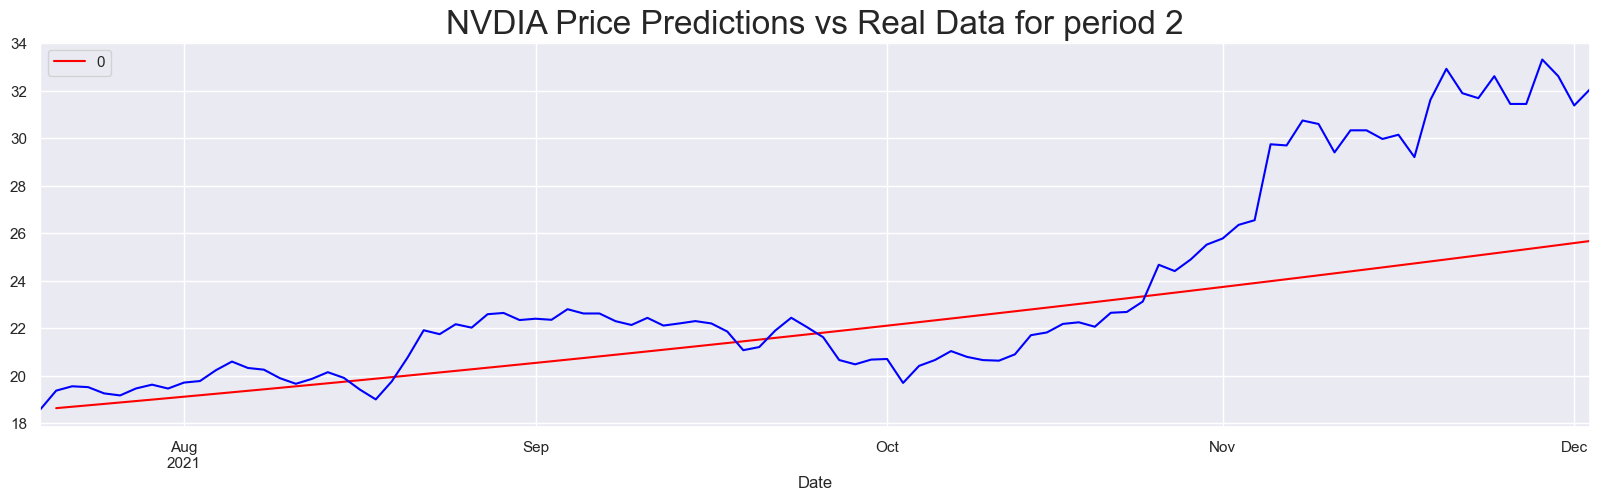

In [50]:
df_prediction_NVDA_close_period1 = pd.DataFrame(model_NVDA_close_period1.predict(n_periods=len(df[announcement_1:announcement_2]), 
                                               exogenous = df[['SFTBY_close','AMD_close','INTC_close']][announcement_1:announcement_2]), 
                                                index = df[announcement_1:announcement_2].index)

df_prediction_NVDA_close_period1[announcement_1:announcement_2].plot(figsize = (20,5), color = "red")
df.NVDA_close[announcement_1:announcement_2].plot(color = 'blue')
plt.title('NVDIA Price Predictions vs Real Data for period 2', size = 24)
plt.show()

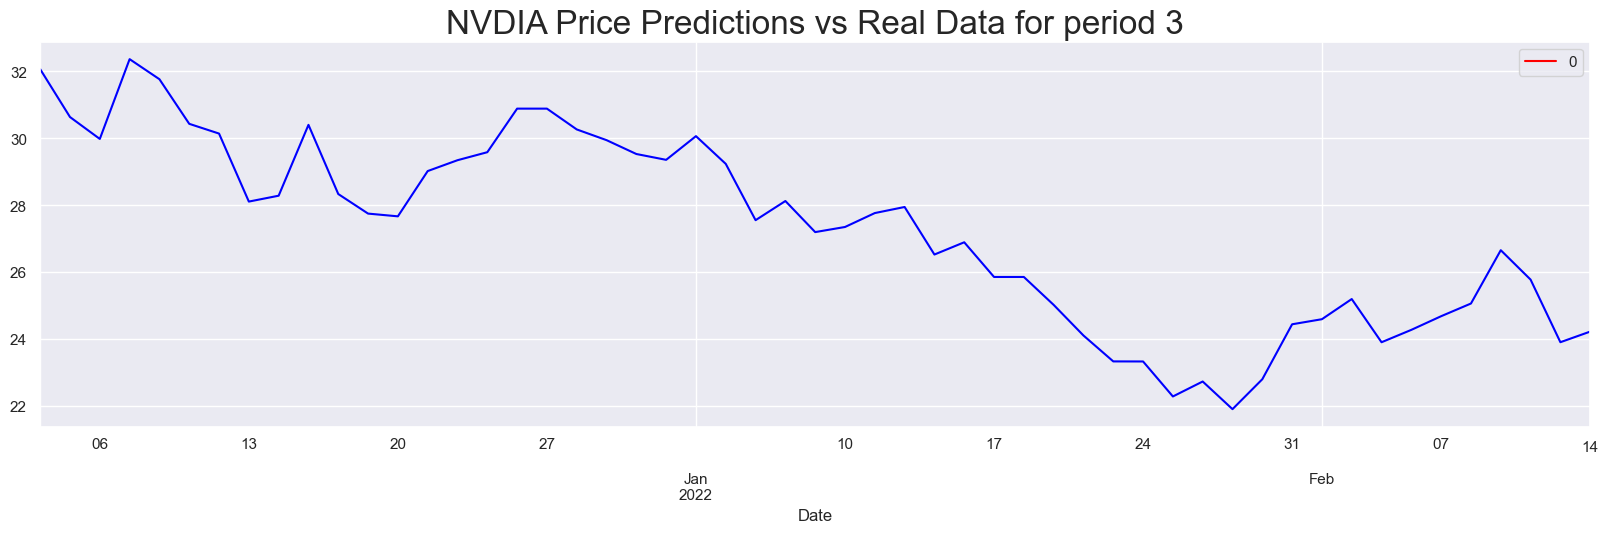

In [51]:
df_prediction_NVDA_close_period2 = pd.DataFrame(model_NVDA_close_period2.predict(n_periods=len(df[announcement_2:end]), 
                                               exogenous = df[['SFTBY_close','AMD_close','INTC_close']][announcement_2:end]), 
                                                index = df[announcement_2:end].index)

df_prediction_NVDA_close_period1[announcement_2:end].plot(figsize = (20,5), color = "red")
df.NVDA_close[announcement_2:end].plot(color = 'blue')
plt.title('NVDIA Price Predictions vs Real Data for period 3', size = 24)
plt.show()

The reason we do not have a model to compare against is because our model auto fit ARIMA(0,1,0) which means the time series integrated itself for stationairy purposes but then did not find a best fitting model, this could be due to the fact that the model is too complicated and should use less exogenous variable or have looser restrictions on the parameters to adjust for longer trends. we will gather more information for validating by obtaining ACF and PACF 

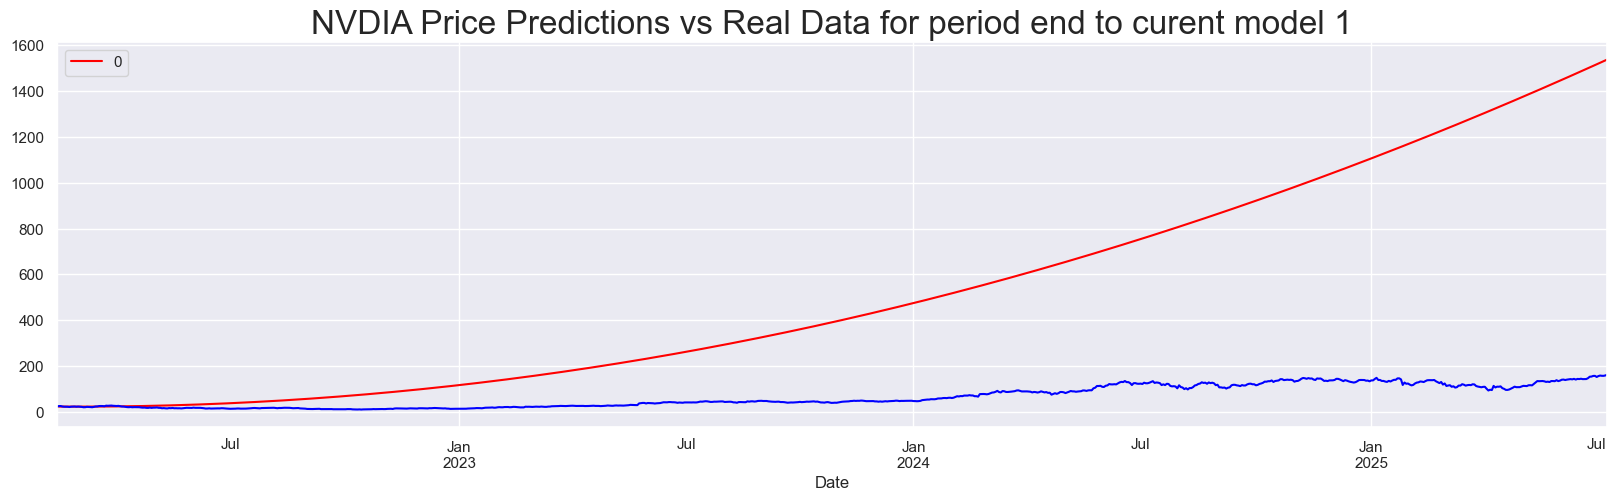

In [52]:
df_prediction_NVDA_close_period3 = pd.DataFrame(model_NVDA_close_period3.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['SFTBY_close','AMD_close','INTC_close']][end:]), 
                                                index = df[end:].index)

df_prediction_NVDA_close_period3[end:].plot(figsize = (20,5), color = "red")
df.NVDA_close[end:].plot(color = 'blue')
plt.title('NVDIA Price Predictions vs Real Data for period end to curent model 1', size = 24)
plt.show()

The graph above is using the model from time period: announcement 2 to end, while the graph below is using the model generated from timer period: start to end

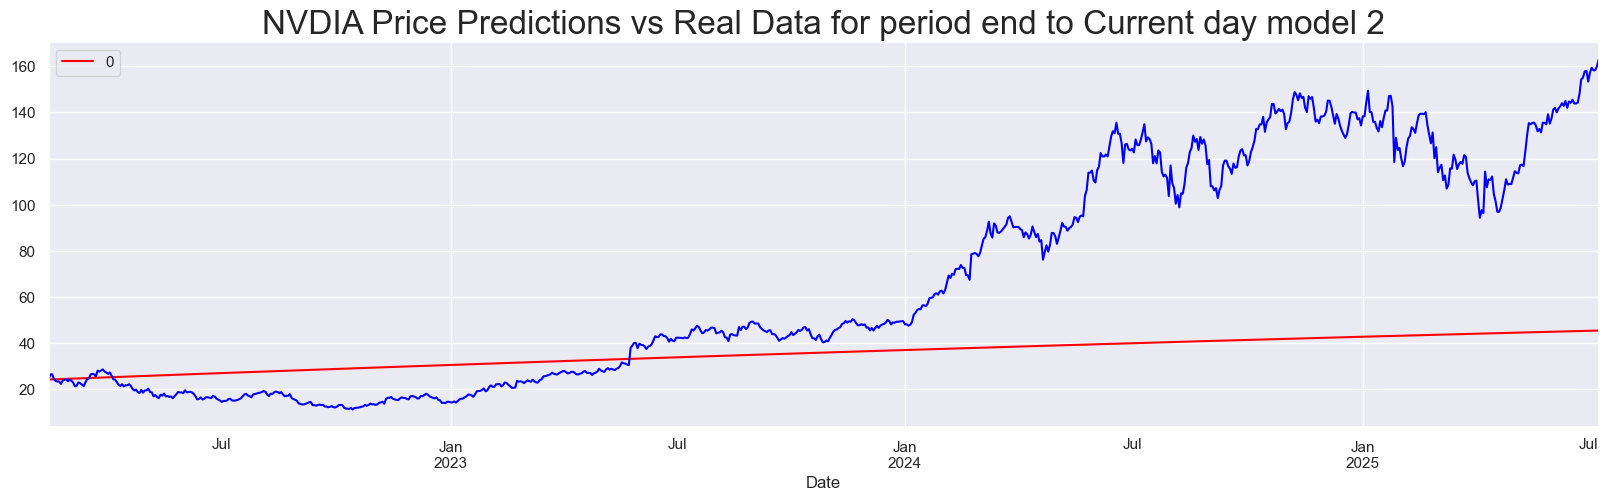

In [53]:
df_prediction_NVDA_close_periodall = pd.DataFrame(model_NVDA_close_period_all.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['SFTBY_close','AMD_close','INTC_close']][end:]), 
                                                index = df[end:].index)

df_prediction_NVDA_close_periodall[end:].plot(figsize = (20,5), color = "red")
df.NVDA_close[end:].plot(color = 'blue')
plt.title('NVDIA Price Predictions vs Real Data for period end to Current day model 2', size = 24)
plt.show()

### NVDIA (LOG) Returns Predictions by Period 

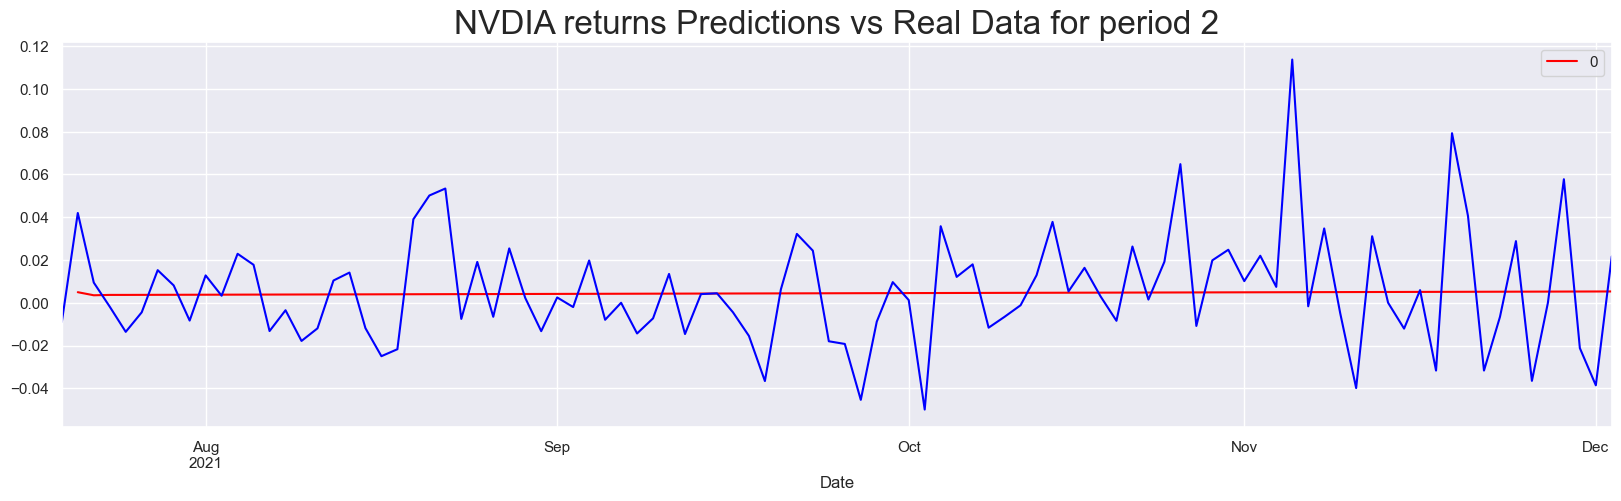

In [54]:
df_prediction_NVDA_log_returns_period1 = pd.DataFrame(model_NVDA_log_returns_period1.predict(n_periods=len(df[announcement_1:announcement_2]), 
                                               exogenous = df[['SFTBY_log_returns','AMD_log_returns','INTC_log_returns']][announcement_1:announcement_2]), 
                                                index = df[announcement_1:announcement_2].index)

df_prediction_NVDA_log_returns_period1[announcement_1:announcement_2].plot(figsize = (20,5), color = "red")
df.NVDA_log_returns[announcement_1:announcement_2].plot(color = 'blue')
plt.title('NVDIA returns Predictions vs Real Data for period 2', size = 24)
plt.show()

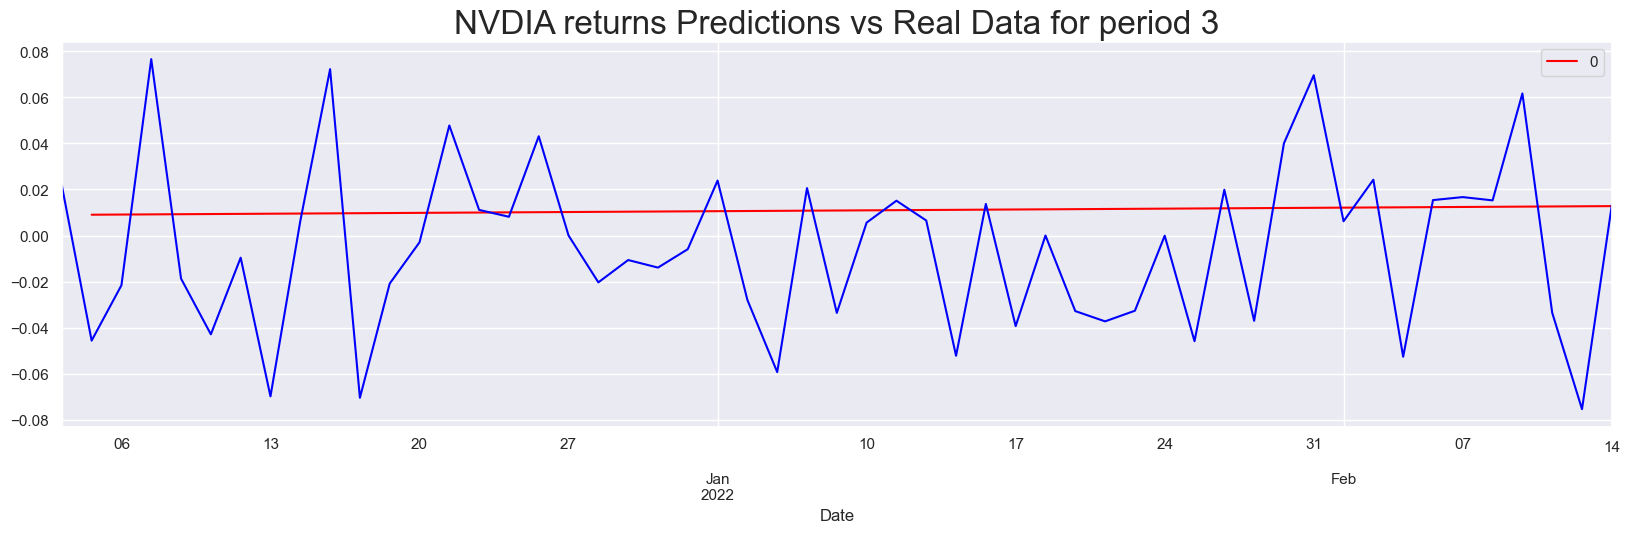

In [55]:
df_prediction_NVDA_log_returns_period2 = pd.DataFrame(model_NVDA_log_returns_period2.predict(n_periods=len(df[announcement_2:end]), 
                                               exogenous = df[['SFTBY_log_returns','AMD_log_returns','INTC_log_returns']][announcement_2:end]), 
                                                index = df[announcement_2:end].index)

df_prediction_NVDA_log_returns_period2[announcement_2:end].plot(figsize = (20,5), color = "red")
df.NVDA_log_returns[announcement_2:end].plot(color = 'blue')
plt.title('NVDIA returns Predictions vs Real Data for period 3', size = 24)
plt.show()

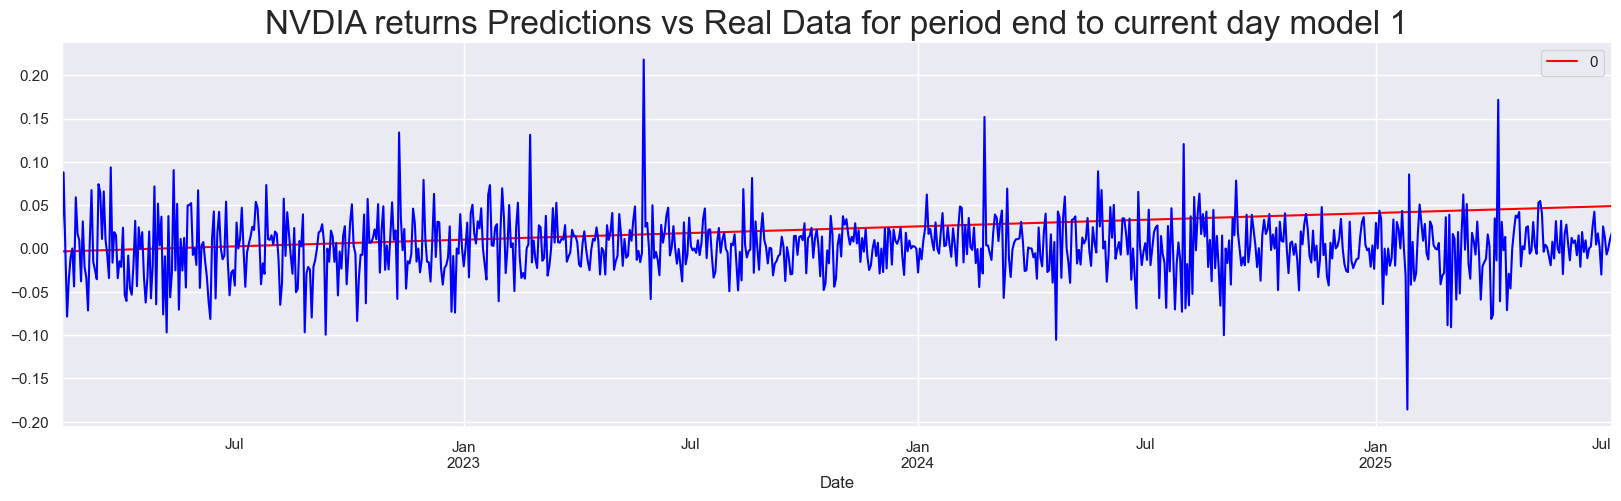

In [56]:
df_prediction_NVDA_log_returns_period3 = pd.DataFrame(model_NVDA_log_returns_period3.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['SFTBY_log_returns','AMD_log_returns','INTC_log_returns']][end:]), 
                                                index = df[end:].index)

df_prediction_NVDA_log_returns_period3[end:].plot(figsize = (20,5), color = "red")
df.NVDA_log_returns[end:].plot(color = 'blue')
plt.title('NVDIA returns Predictions vs Real Data for period end to current day model 1', size = 24)
plt.show()

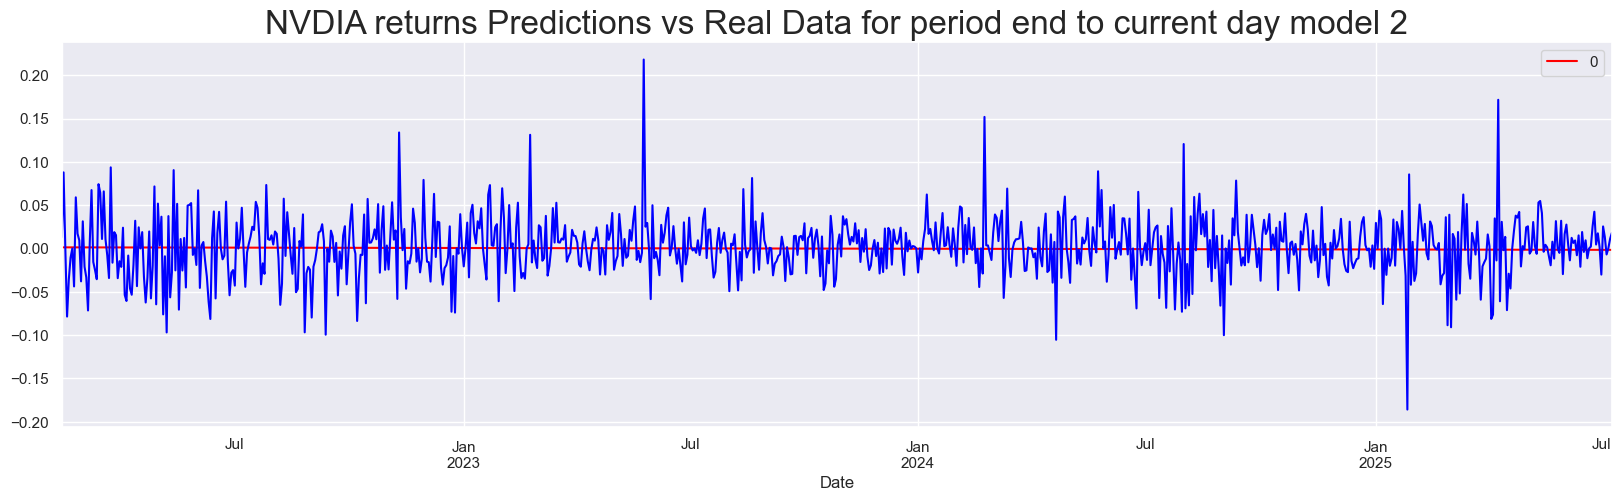

In [57]:
df_prediction_NVDA_log_returns_periodall = pd.DataFrame(model_NVDA_log_returns_period_all.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['SFTBY_log_returns','AMD_log_returns','INTC_log_returns']][end:]), 
                                                index = df[end:].index)

df_prediction_NVDA_log_returns_periodall[end:].plot(figsize = (20,5), color = "red")
df.NVDA_log_returns[end:].plot(color = 'blue')
plt.title('NVDIA returns Predictions vs Real Data for period end to current day model 2', size = 24)
plt.show()

### NVDIA Volume Predictions by Period 

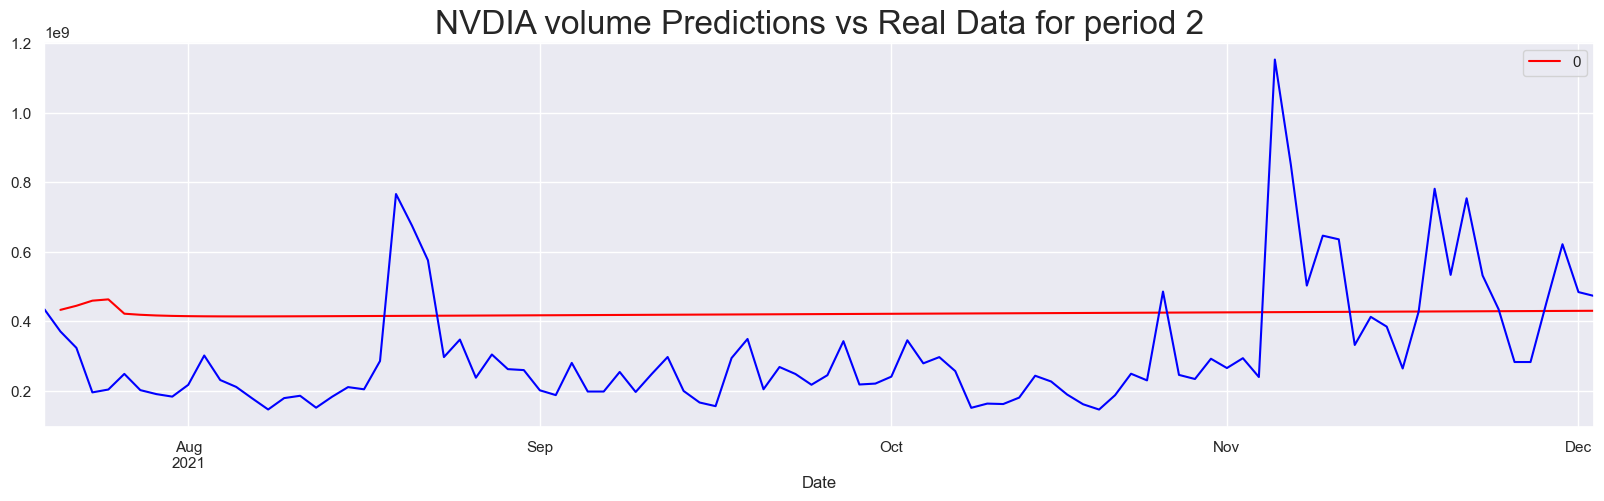

In [58]:
df_prediction_NVDA_volume_period1 = pd.DataFrame(model_NVDA_volume_period1.predict(n_periods=len(df[announcement_1:announcement_2]), 
                                               exogenous = df[['SFTBY_volume','AMD_volume','INTC_volume']][announcement_1:announcement_2]), 
                                                index = df[announcement_1:announcement_2].index)

df_prediction_NVDA_volume_period1[announcement_1:announcement_2].plot(figsize = (20,5), color = "red")
df.NVDA_volume[announcement_1:announcement_2].plot(color = 'blue')
plt.title('NVDIA volume Predictions vs Real Data for period 2', size = 24)
plt.show()

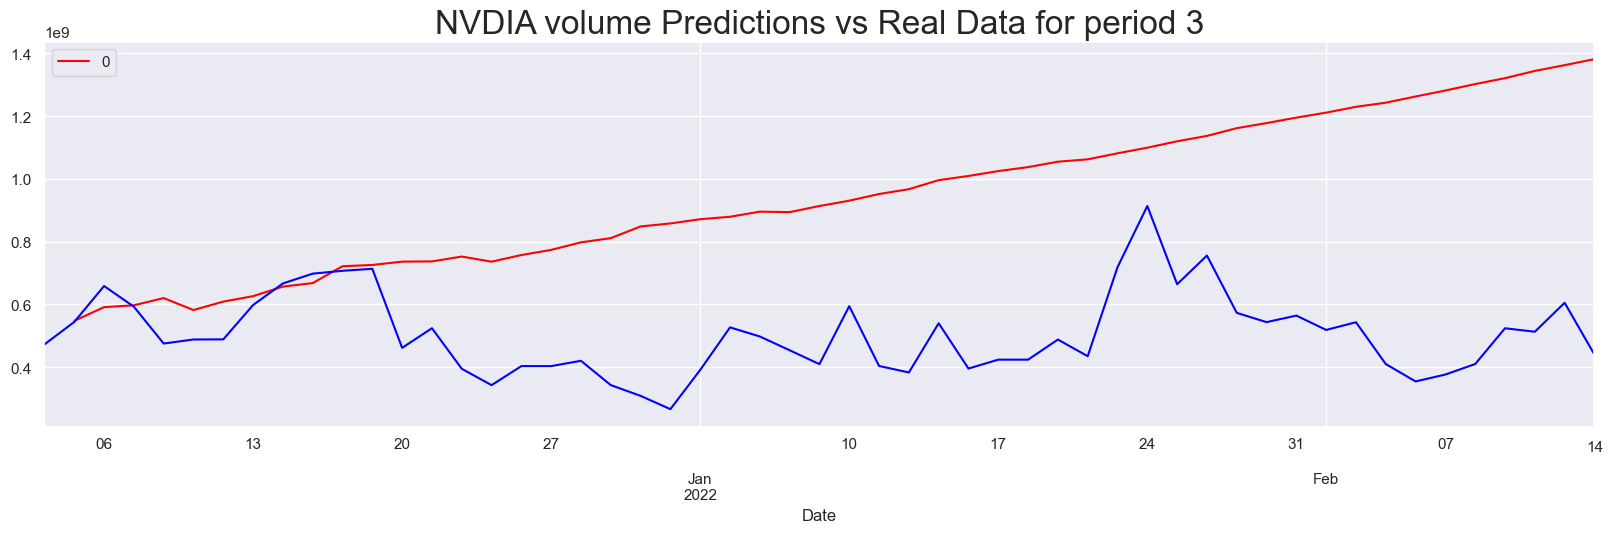

In [59]:
df_prediction_NVDA_volume_period2 = pd.DataFrame(model_NVDA_volume_period2.predict(n_periods=len(df[announcement_2:end]), 
                                               exogenous = df[['SFTBY_volume','AMD_volume','INTC_volume']][announcement_2:end]), 
                                                index = df[announcement_2:end].index)

df_prediction_NVDA_volume_period2[announcement_2:end].plot(figsize = (20,5), color = "red")
df.NVDA_volume[announcement_2:end].plot(color = 'blue')
plt.title('NVDIA volume Predictions vs Real Data for period 3', size = 24)
plt.show()

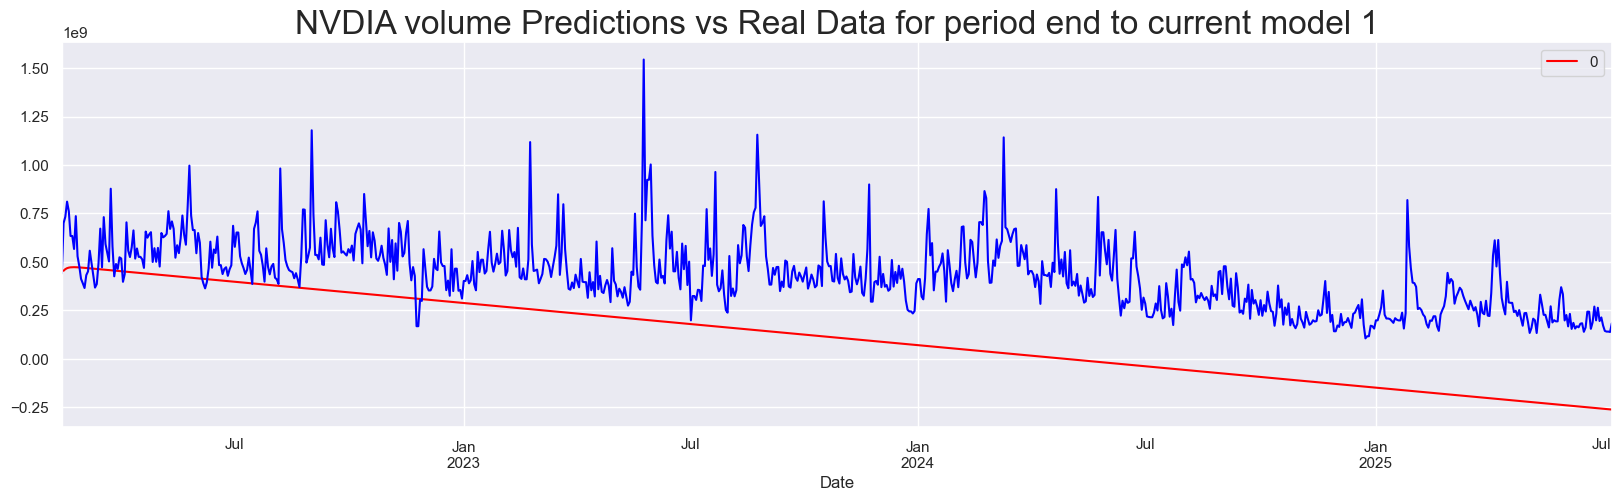

In [60]:
df_prediction_NVDA_volume_period3 = pd.DataFrame(model_NVDA_volume_period3.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['SFTBY_volume','AMD_volume','INTC_volume']][end:]), 
                                                index = df[end:].index)

df_prediction_NVDA_volume_period3[end:].plot(figsize = (20,5), color = "red")
df.NVDA_volume[end:].plot(color = 'blue')
plt.title('NVDIA volume Predictions vs Real Data for period end to current model 1', size = 24)
plt.show()

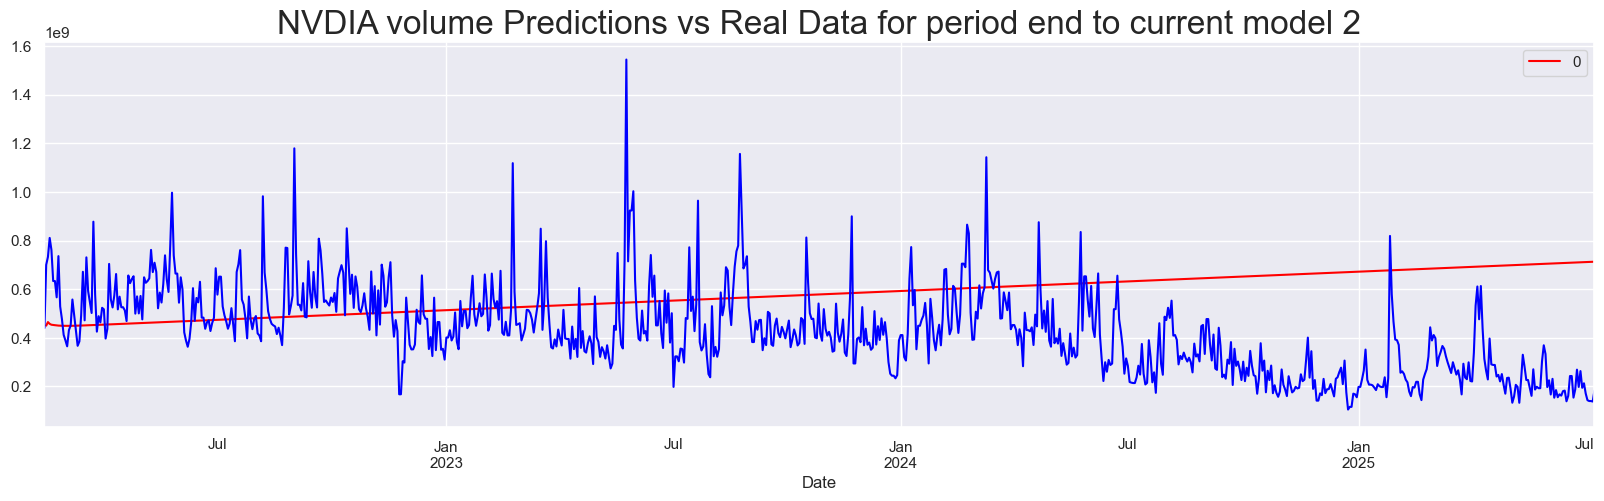

In [61]:
df_prediction_NVDA_volume_periodall = pd.DataFrame(model_NVDA_volume_period_all.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['SFTBY_volume','AMD_volume','INTC_volume']][end:]), 
                                                index = df[end:].index)

df_prediction_NVDA_volume_periodall[end:].plot(figsize = (20,5), color = "red")
df.NVDA_volume[end:].plot(color = 'blue')
plt.title('NVDIA volume Predictions vs Real Data for period end to current model 2', size = 24)
plt.show()

## SOFTBANK Predictions 

The next step is to repeat the predictions for softbank. the look into the ACF, PACF, and residuals then hopefully cover with some volatility testing using the squared log returns data column

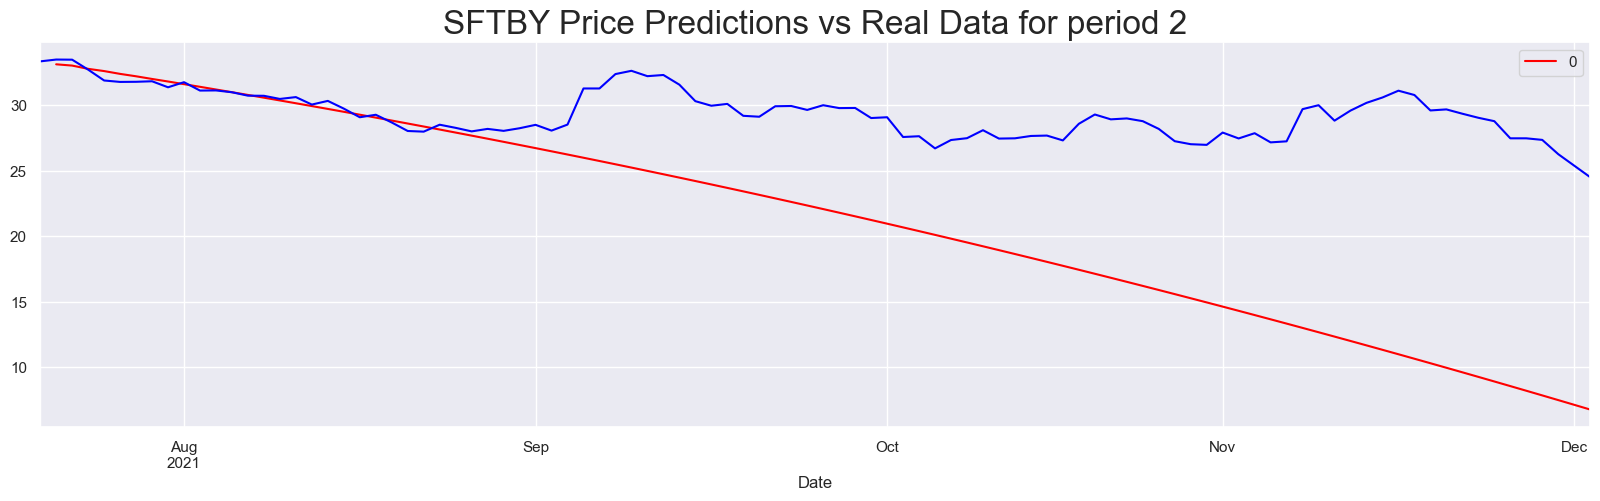

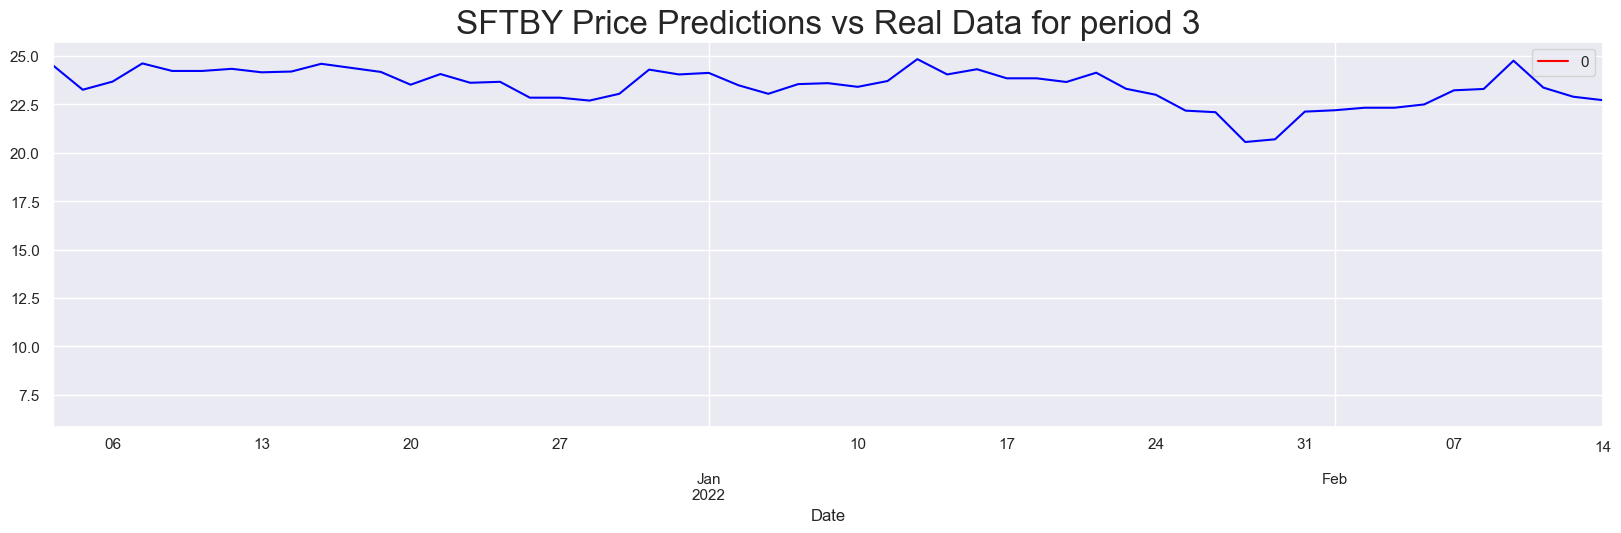

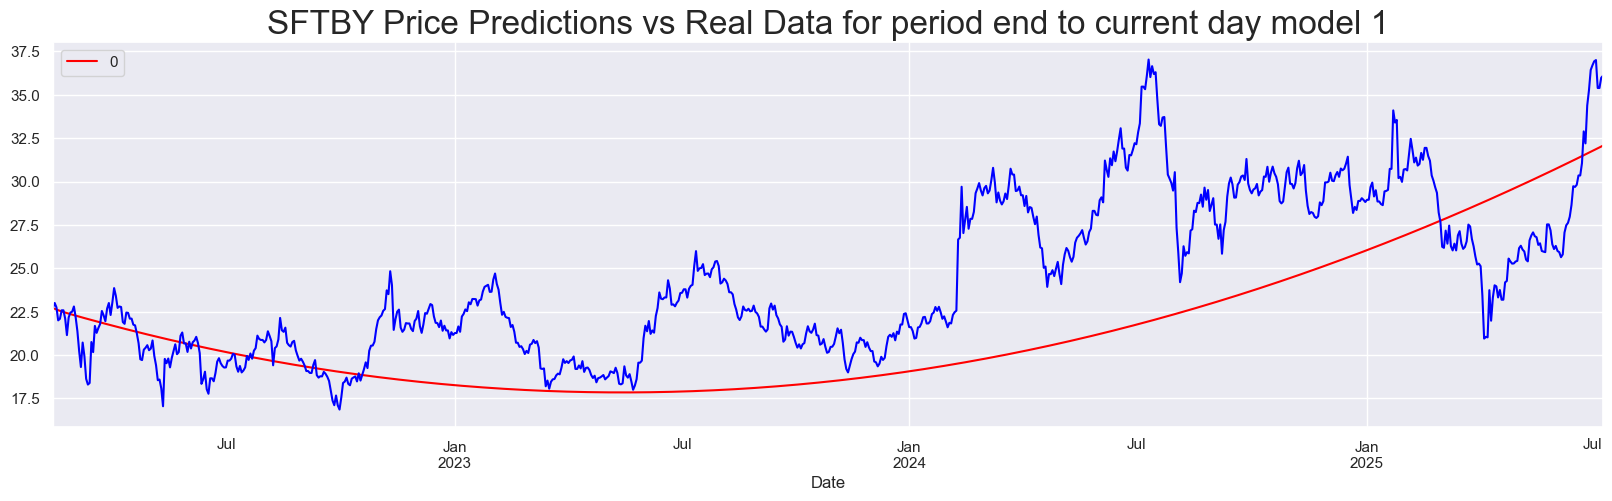

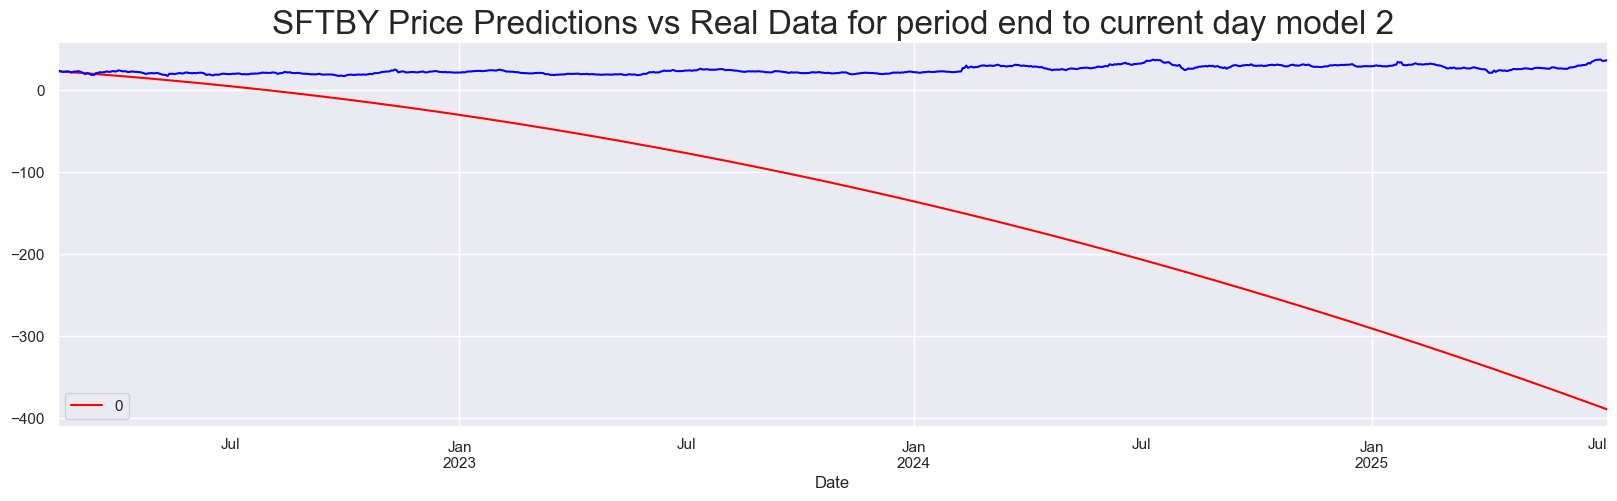

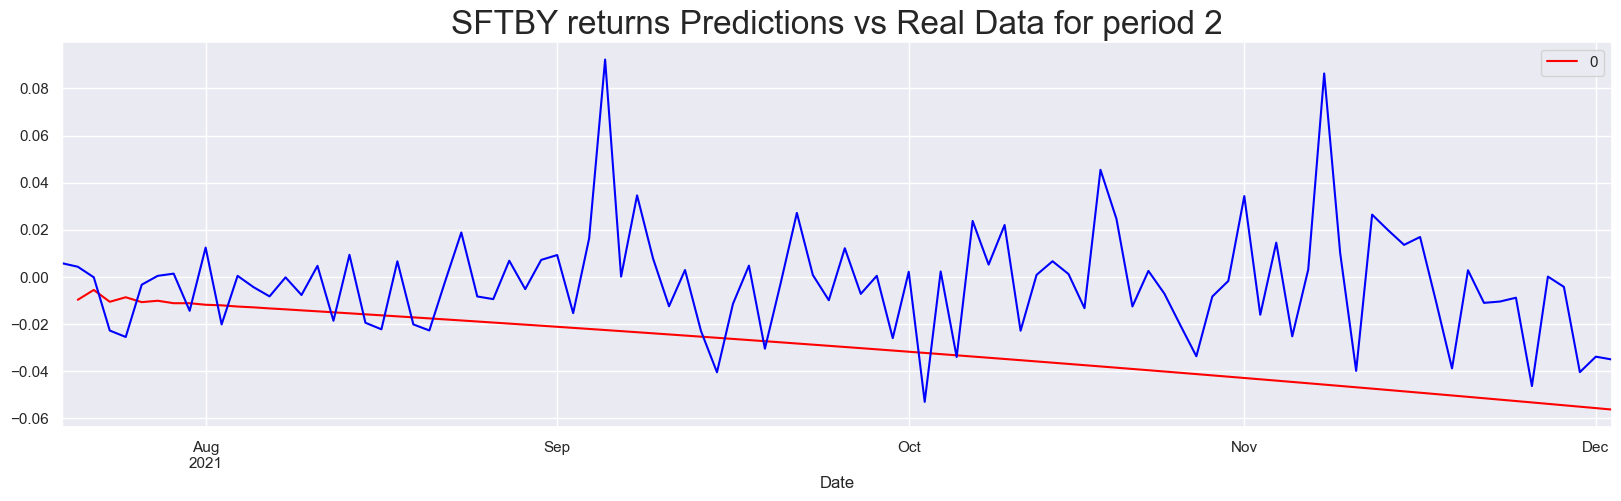

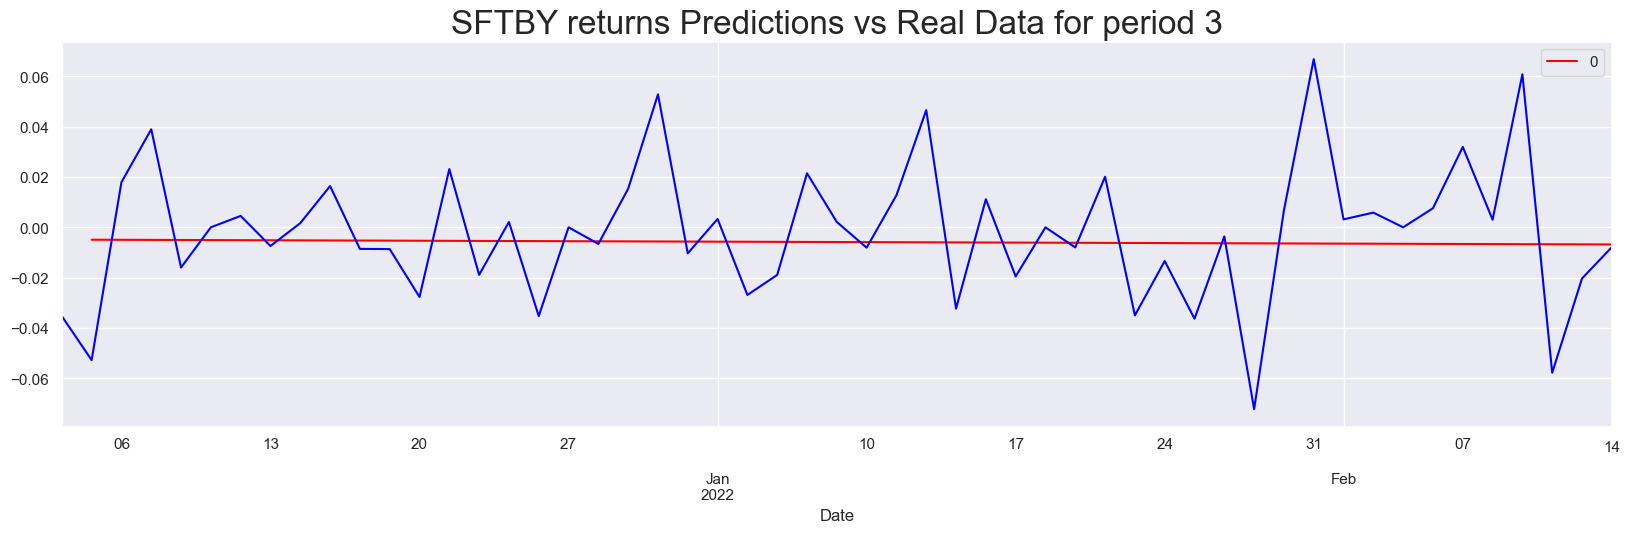

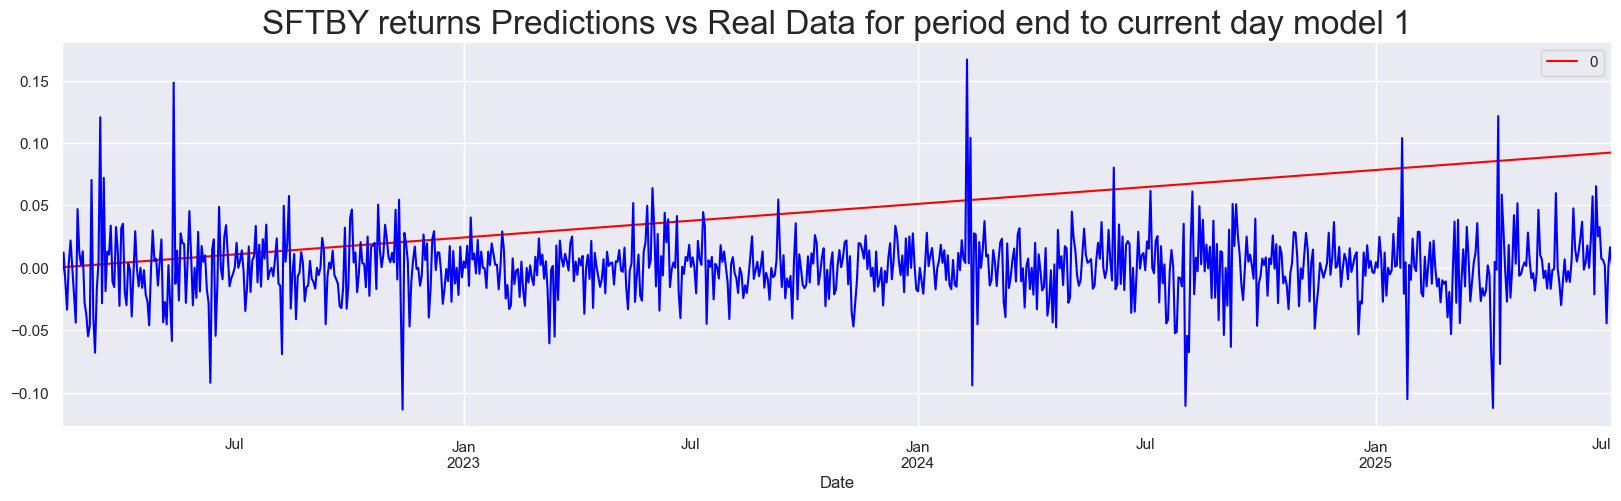

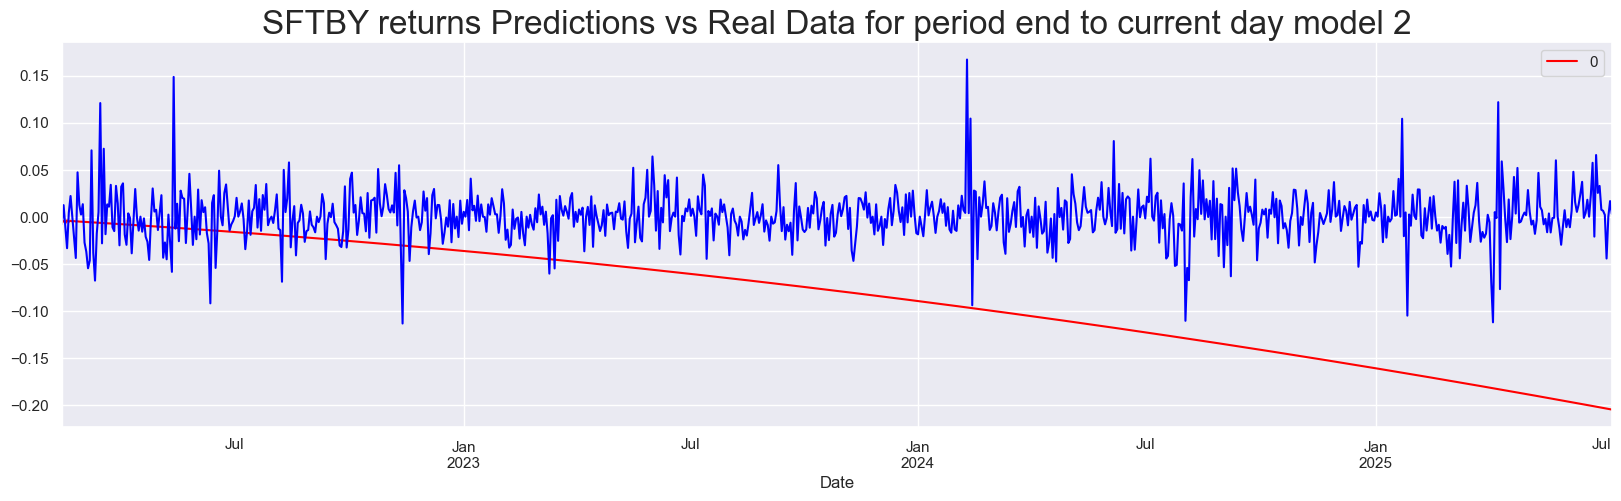

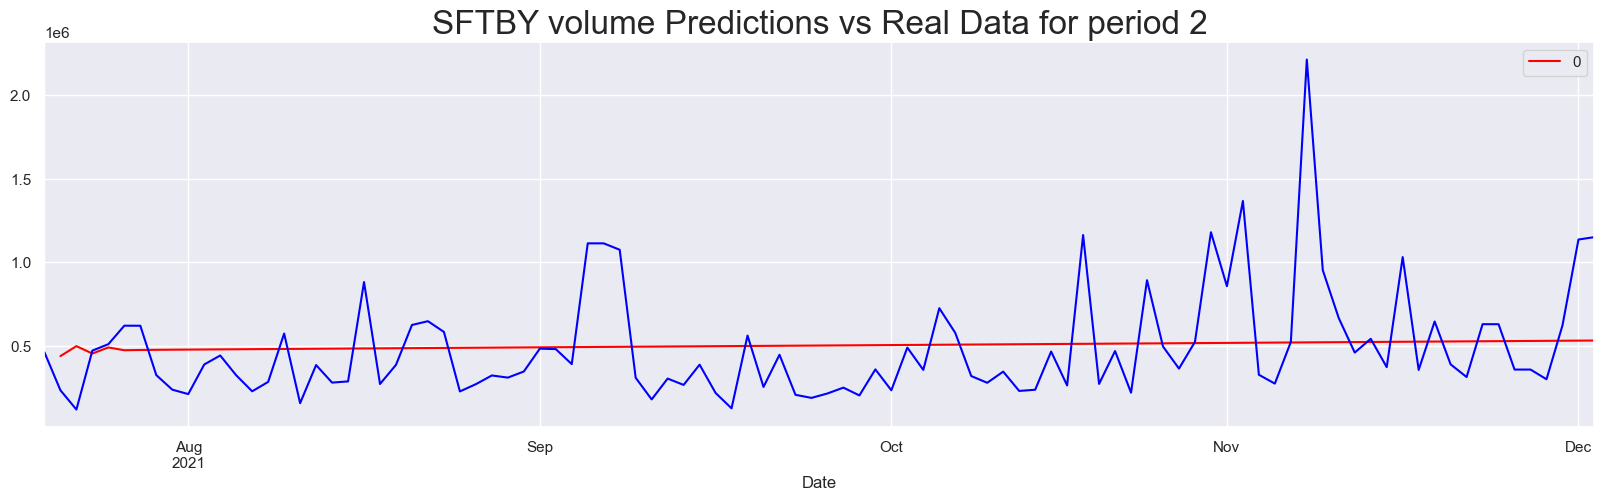

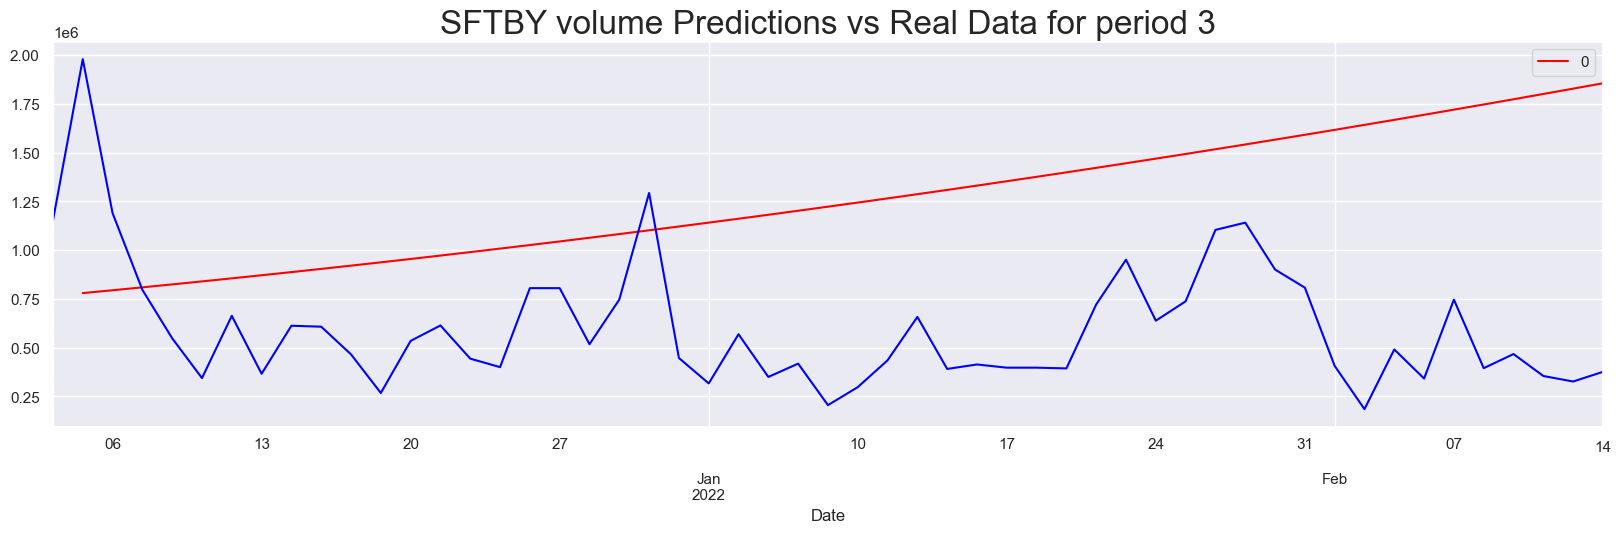

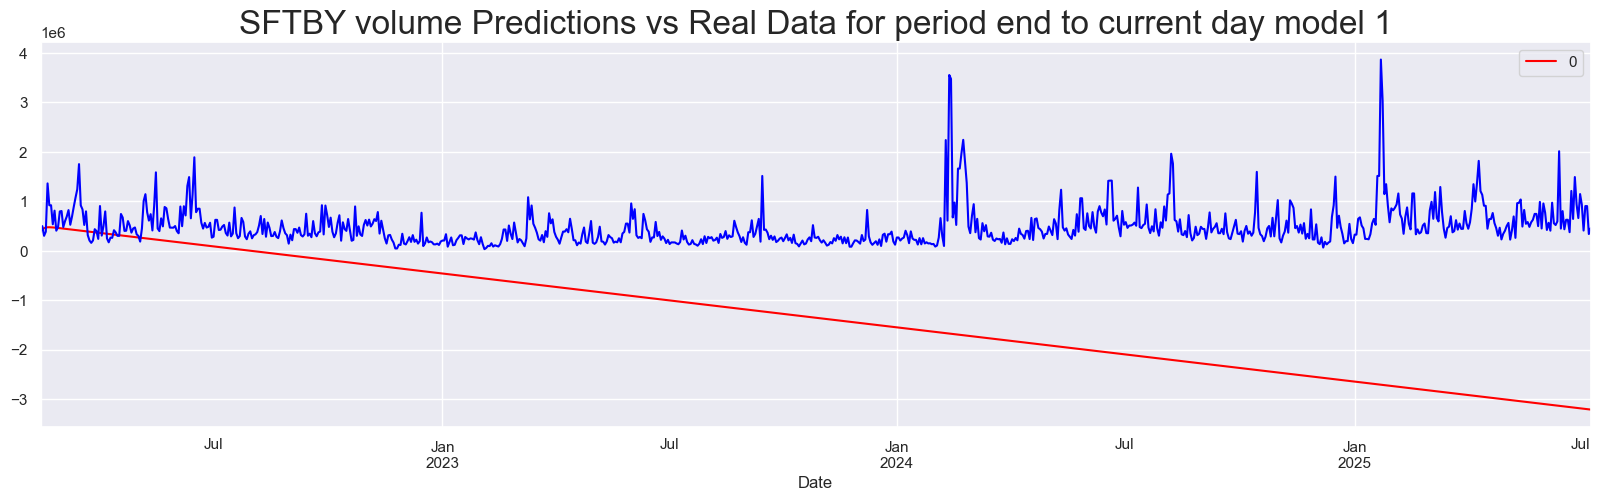

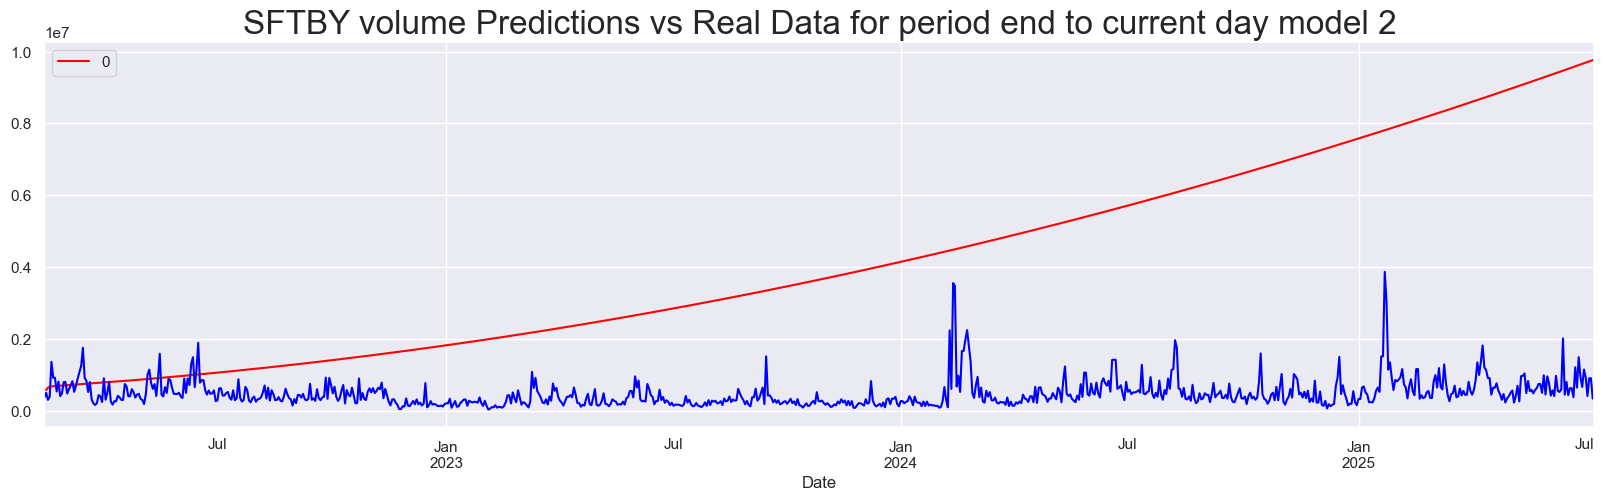

In [62]:
df_prediction_SFTBY_close_period1 = pd.DataFrame(model_SFTBY_close_period1.predict(n_periods=len(df[announcement_1:announcement_2]), 
                                               exogenous = df[['NVDA_close','AMD_close','INTC_close']][announcement_1:announcement_2]), 
                                                index = df[announcement_1:announcement_2].index)

df_prediction_SFTBY_close_period1[announcement_1:announcement_2].plot(figsize = (20,5), color = "red")
df.SFTBY_close[announcement_1:announcement_2].plot(color = 'blue')
plt.title('SFTBY Price Predictions vs Real Data for period 2', size = 24)
plt.show()

df_prediction_SFTBY_close_period2 = pd.DataFrame(model_SFTBY_close_period2.predict(n_periods=len(df[announcement_2:end]), 
                                               exogenous = df[['NVDA_close','AMD_close','INTC_close']][announcement_2:end]), 
                                                index = df[announcement_2:end].index)

df_prediction_SFTBY_close_period1[announcement_2:end].plot(figsize = (20,5), color = "red")
df.SFTBY_close[announcement_2:end].plot(color = 'blue')
plt.title('SFTBY Price Predictions vs Real Data for period 3', size = 24)
plt.show()

df_prediction_SFTBY_close_period3 = pd.DataFrame(model_SFTBY_close_period3.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['NVDA_close','AMD_close','INTC_close']][end:]), 
                                                index = df[end:].index)

df_prediction_SFTBY_close_period3[end:].plot(figsize = (20,5), color = "red")
df.SFTBY_close[end:].plot(color = 'blue')
plt.title('SFTBY Price Predictions vs Real Data for period end to current day model 1', size = 24)
plt.show()

df_prediction_SFTBY_close_periodall = pd.DataFrame(model_SFTBY_close_period_all.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['NVDA_close','AMD_close','INTC_close']][end:]), 
                                                index = df[end:].index)

df_prediction_SFTBY_close_periodall[end:].plot(figsize = (20,5), color = "red")
df.SFTBY_close[end:].plot(color = 'blue')
plt.title('SFTBY Price Predictions vs Real Data for period end to current day model 2', size = 24)
plt.show()

df_prediction_SFTBY_log_returns_period1 = pd.DataFrame(model_SFTBY_log_returns_period1.predict(n_periods=len(df[announcement_1:announcement_2]), 
                                               exogenous = df[['NVDA_log_returns','AMD_log_returns','INTC_log_returns']][announcement_1:announcement_2]), 
                                                index = df[announcement_1:announcement_2].index)

df_prediction_SFTBY_log_returns_period1[announcement_1:announcement_2].plot(figsize = (20,5), color = "red")
df.SFTBY_log_returns[announcement_1:announcement_2].plot(color = 'blue')
plt.title('SFTBY returns Predictions vs Real Data for period 2', size = 24)
plt.show()

df_prediction_SFTBY_log_returns_period2 = pd.DataFrame(model_SFTBY_log_returns_period2.predict(n_periods=len(df[announcement_2:end]), 
                                               exogenous = df[['NVDA_log_returns','AMD_log_returns','INTC_log_returns']][announcement_2:end]), 
                                                index = df[announcement_2:end].index)

df_prediction_SFTBY_log_returns_period2[announcement_2:end].plot(figsize = (20,5), color = "red")
df.SFTBY_log_returns[announcement_2:end].plot(color = 'blue')
plt.title('SFTBY returns Predictions vs Real Data for period 3', size = 24)
plt.show()

df_prediction_SFTBY_log_returns_period3 = pd.DataFrame(model_SFTBY_log_returns_period3.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['NVDA_log_returns','AMD_log_returns','INTC_log_returns']][end:]), 
                                                index = df[end:].index)

df_prediction_SFTBY_log_returns_period3[end:].plot(figsize = (20,5), color = "red")
df.SFTBY_log_returns[end:].plot(color = 'blue')
plt.title('SFTBY returns Predictions vs Real Data for period end to current day model 1', size = 24)
plt.show()

df_prediction_SFTBY_log_returns_periodall = pd.DataFrame(model_SFTBY_log_returns_period_all.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['NVDA_log_returns','AMD_log_returns','INTC_log_returns']][end:]), 
                                                index = df[end:].index)

df_prediction_SFTBY_log_returns_periodall[end:].plot(figsize = (20,5), color = "red")
df.SFTBY_log_returns[end:].plot(color = 'blue')
plt.title('SFTBY returns Predictions vs Real Data for period end to current day model 2', size = 24)
plt.show()

df_prediction_SFTBY_volume_period1 = pd.DataFrame(model_SFTBY_volume_period1.predict(n_periods=len(df[announcement_1:announcement_2]), 
                                               exogenous = df[['NVDA_volume','AMD_volume','INTC_volume']][announcement_1:announcement_2]), 
                                                index = df[announcement_1:announcement_2].index)

df_prediction_SFTBY_volume_period1[announcement_1:announcement_2].plot(figsize = (20,5), color = "red")
df.SFTBY_volume[announcement_1:announcement_2].plot(color = 'blue')
plt.title('SFTBY volume Predictions vs Real Data for period 2', size = 24)
plt.show()

df_prediction_SFTBY_volume_period2 = pd.DataFrame(model_SFTBY_volume_period2.predict(n_periods=len(df[announcement_2:end]), 
                                               exogenous = df[['NVDA_volume','AMD_volume','INTC_volume']][announcement_2:end]), 
                                                index = df[announcement_2:end].index)

df_prediction_SFTBY_volume_period2[announcement_2:end].plot(figsize = (20,5), color = "red")
df.SFTBY_volume[announcement_2:end].plot(color = 'blue')
plt.title('SFTBY volume Predictions vs Real Data for period 3', size = 24)
plt.show()

df_prediction_SFTBY_volume_period3 = pd.DataFrame(model_SFTBY_volume_period3.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['NVDA_volume','AMD_volume','INTC_volume']][end:]), 
                                                index = df[end:].index)

df_prediction_SFTBY_volume_period3[end:].plot(figsize = (20,5), color = "red")
df.SFTBY_volume[end:].plot(color = 'blue')
plt.title('SFTBY volume Predictions vs Real Data for period end to current day model 1', size = 24)
plt.show()

df_prediction_SFTBY_volume_periodall = pd.DataFrame(model_SFTBY_volume_period_all.predict(n_periods=len(df[end:]), 
                                               exogenous = df[['NVDA_volume','AMD_volume','INTC_volume']][end:]), 
                                                index = df[end:].index)

df_prediction_SFTBY_volume_periodall[end:].plot(figsize = (20,5), color = "red")
df.SFTBY_volume[end:].plot(color = 'blue')
plt.title('SFTBY volume Predictions vs Real Data for period end to current day model 2', size = 24)
plt.show()

## ACF, PACF for Prices, Log Returns, returns squared(Volatility)and Volume

### NVDIA

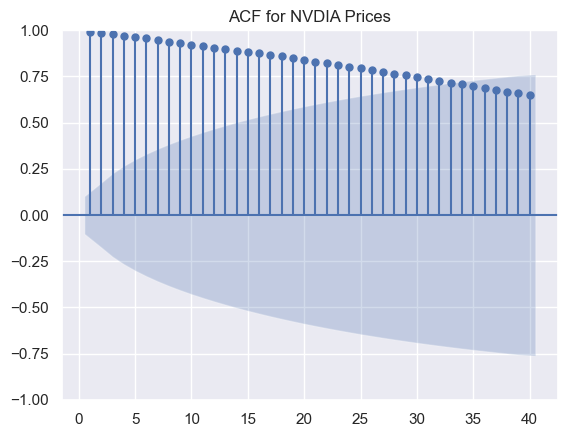

In [63]:
sgt.plot_acf(df.NVDA_close[start:end], zero = False, lags = 40)
plt.title("ACF for NVDIA Prices")
plt.show()

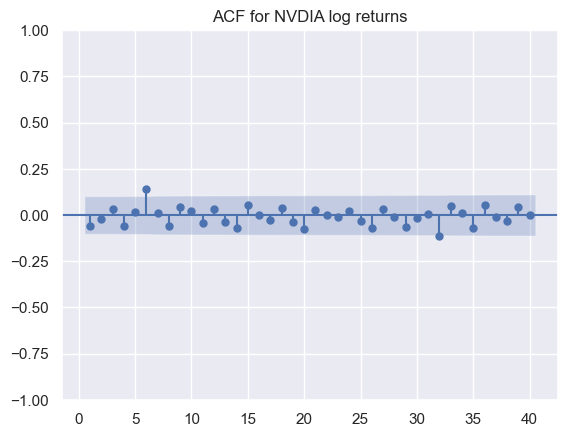

In [64]:
sgt.plot_acf(df.NVDA_log_returns[start:end], zero = False, lags = 40)
plt.title("ACF for NVDIA log returns")
plt.show()

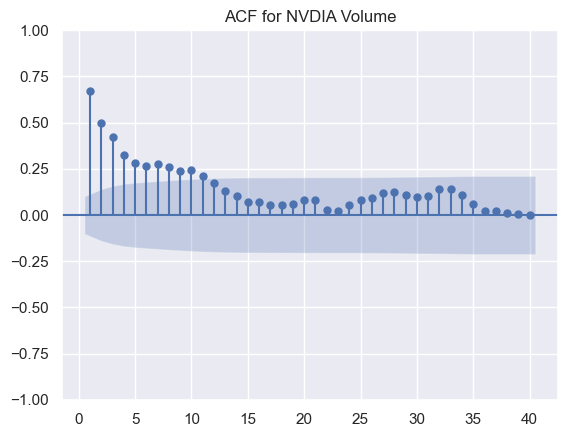

In [65]:
sgt.plot_acf(df.NVDA_volume[start:end], zero = False, lags = 40)
plt.title("ACF for NVDIA Volume")
plt.show()

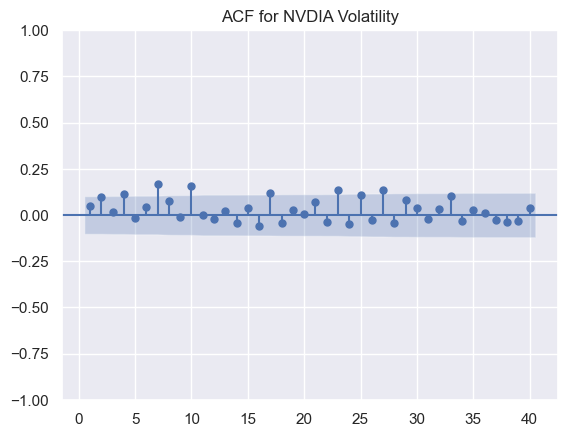

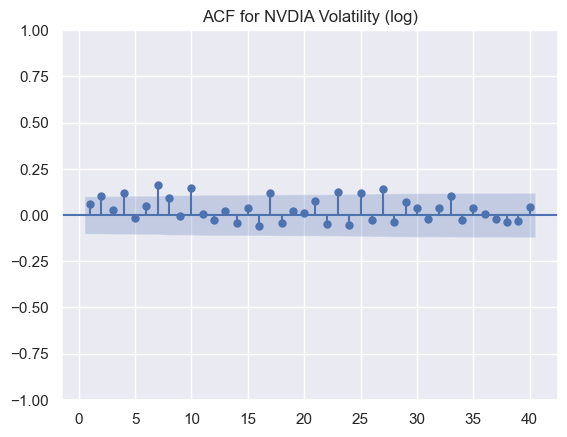

In [66]:
sgt.plot_acf(df.NVDA_sq_returns[start:end], zero = False, lags = 40)
plt.title("ACF for NVDIA Volatility")
plt.show()
sgt.plot_acf(df.NVDA_sq_log_returns[start:end], zero = False, lags = 40)
plt.title("ACF for NVDIA Volatility (log)")
plt.show()

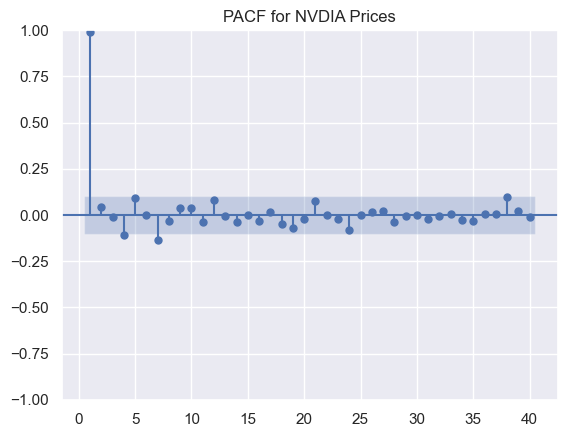

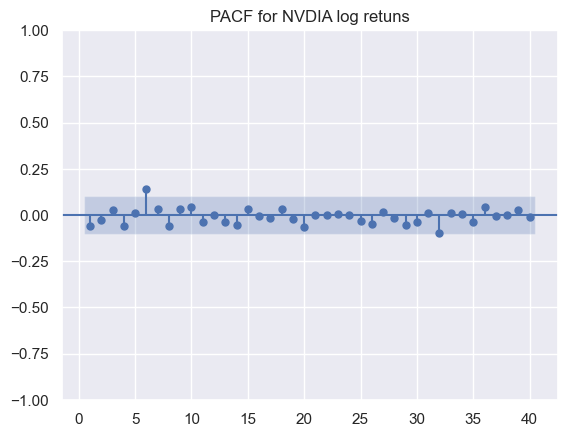

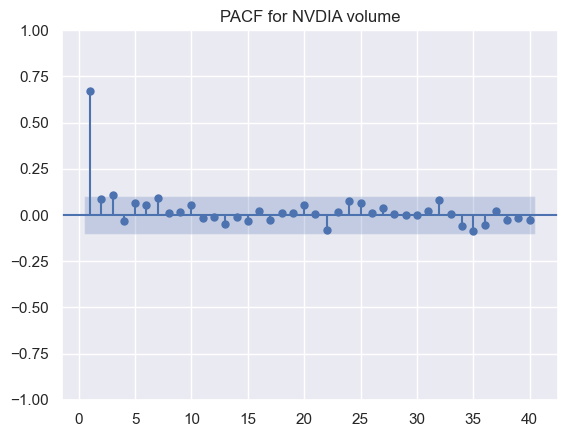

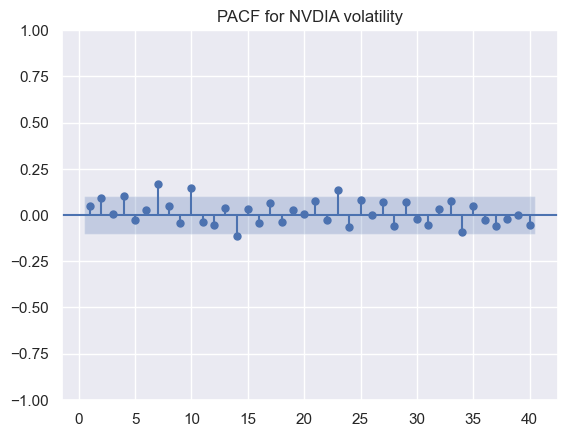

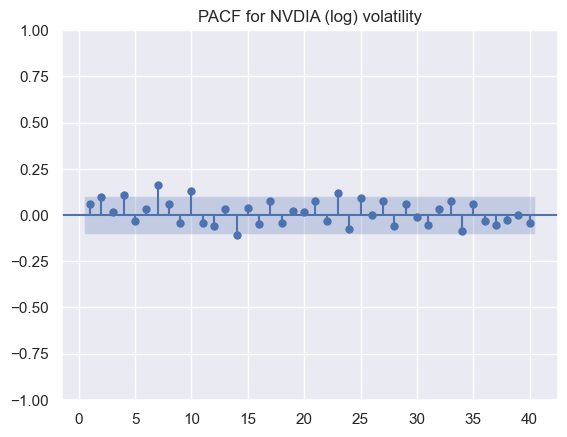

In [67]:
sgt.plot_pacf(df.NVDA_close[start:end], zero = False, lags = 40)
plt.title("PACF for NVDIA Prices")
plt.show()

sgt.plot_pacf(df.NVDA_log_returns[start:end], zero = False, lags = 40)
plt.title("PACF for NVDIA log retuns")
plt.show()

sgt.plot_pacf(df.NVDA_volume[start:end], zero = False, lags = 40)
plt.title("PACF for NVDIA volume")
plt.show()

sgt.plot_pacf(df.NVDA_sq_returns[start:end], zero = False, lags = 40)
plt.title("PACF for NVDIA volatility")
plt.show()

sgt.plot_pacf(df.NVDA_sq_log_returns[start:end], zero = False, lags = 40)
plt.title("PACF for NVDIA (log) volatility")
plt.show()

Comments: this looks into the data from the start of our buyout to the end. The shaded blue area corresponds with significant lags that can be used for the model. 

For Prices: The ACF suggests each lag for auto regressive (p) is signifcant up to 32 lags and the PACF suggest anything after the 7th lag is not signifant for the moving average portion of the function (q)

Log returns: AR (p) of max 6 and MA (q) of max 6

Volume: AR (p) of max 10 and MA (q) of max 1

volatility (returns squared) : AR (p) of max 27 and MA (q) of max 23

Anything that comes after these values for our modeling is not relevant

### SOFTBANK

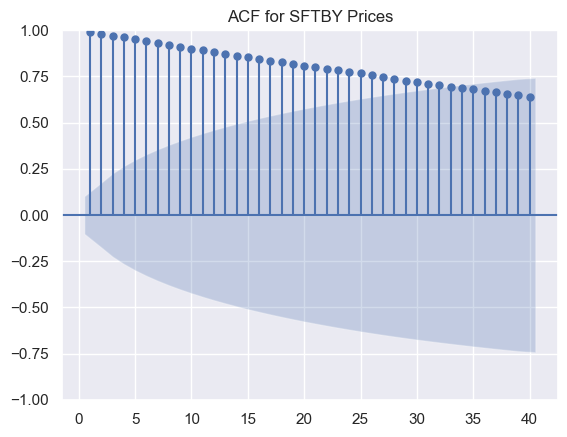

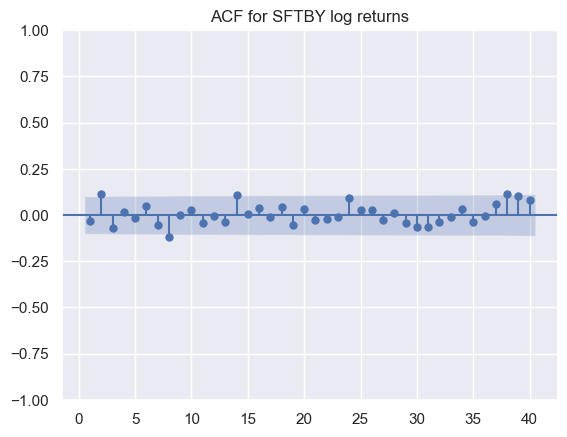

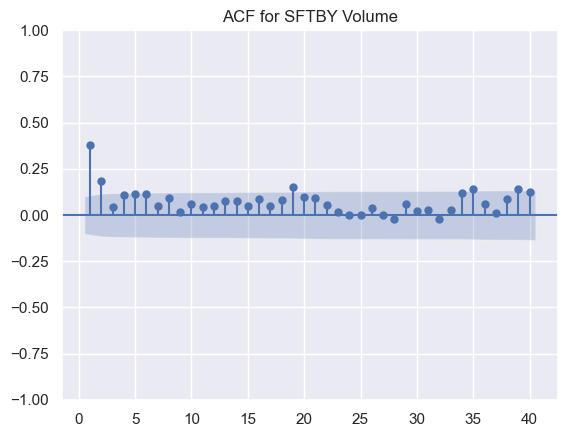

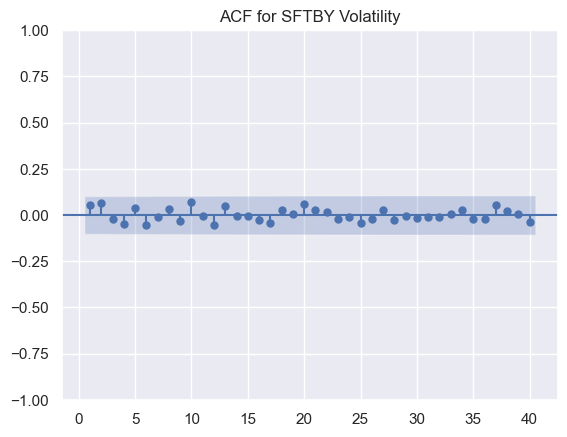

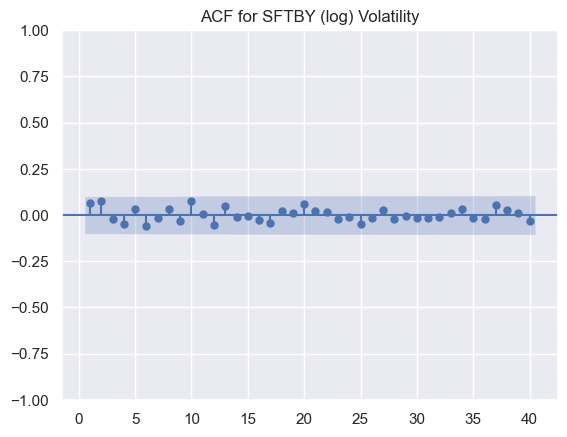

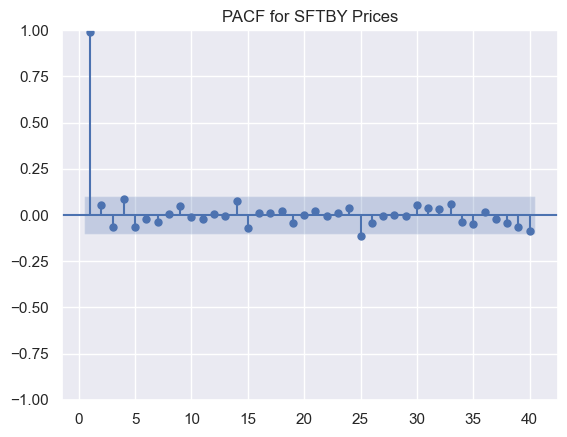

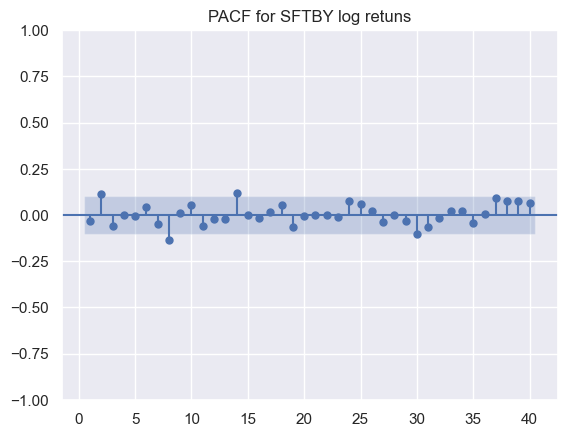

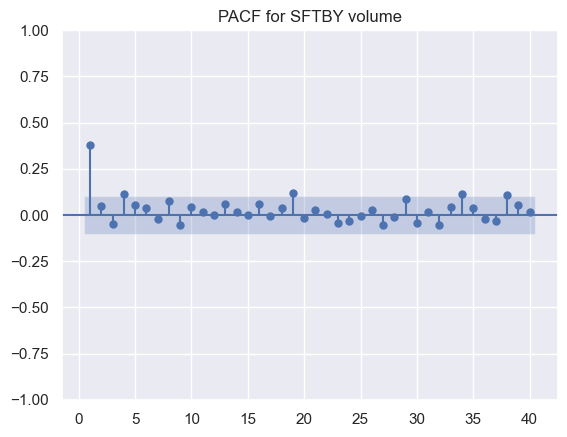

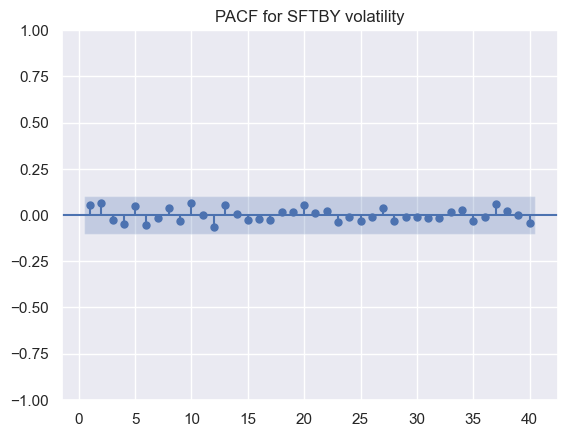

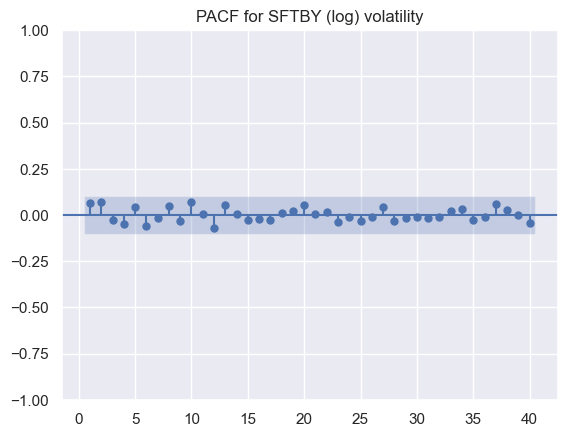

In [68]:
sgt.plot_acf(df.SFTBY_close[start:end], zero = False, lags = 40)
plt.title("ACF for SFTBY Prices")
plt.show()

sgt.plot_acf(df.SFTBY_log_returns[start:end], zero = False, lags = 40)
plt.title("ACF for SFTBY log returns")
plt.show()

sgt.plot_acf(df.SFTBY_volume[start:end], zero = False, lags = 40)
plt.title("ACF for SFTBY Volume")
plt.show()

sgt.plot_acf(df.SFTBY_sq_returns[start:end], zero = False, lags = 40)
plt.title("ACF for SFTBY Volatility")
plt.show()

sgt.plot_acf(df.SFTBY_sq_log_returns[start:end], zero = False, lags = 40)
plt.title("ACF for SFTBY (log) Volatility")
plt.show()

sgt.plot_pacf(df.SFTBY_close[start:end], zero = False, lags = 40)
plt.title("PACF for SFTBY Prices")
plt.show()

sgt.plot_pacf(df.SFTBY_log_returns[start:end], zero = False, lags = 40)
plt.title("PACF for SFTBY log retuns")
plt.show()

sgt.plot_pacf(df.SFTBY_volume[start:end], zero = False, lags = 40)
plt.title("PACF for SFTBY volume")
plt.show()

sgt.plot_pacf(df.SFTBY_sq_returns[start:end], zero = False, lags = 40)
plt.title("PACF for SFTBY volatility")
plt.show()


sgt.plot_pacf(df.SFTBY_sq_log_returns[start:end], zero = False, lags = 40)
plt.title("PACF for SFTBY (log) volatility")
plt.show()

Similary to Before 
Prices: p = 31, q = 1 
Volume: p = 39, q = 39
Log returns: p = 19, q = 19
volatility: p = 1, q = 1

Thes values will be reinstered into our model generation

## Testing for stationarity

## NVDIA 

In [69]:
sts.adfuller(df.NVDA_close[start:end])

(-1.1520013322314797,
 0.6938955142833128,
 6,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 630.4684727223278)

In [70]:
sts.adfuller(df.NVDA_returns[start:end])

(-20.45985078560378,
 0.0,
 0,
 370,
 {'1%': -3.448147967010838,
  '5%': -2.8693833397824413,
  '10%': -2.5709483564645725},
 1729.176927232469)

In [71]:
sts.adfuller(df.NVDA_log_returns[start:end])

(-20.45452098458291,
 0.0,
 0,
 370,
 {'1%': -3.448147967010838,
  '5%': -2.8693833397824413,
  '10%': -2.5709483564645725},
 -1524.587708345121)

In [72]:
sts.adfuller(df.NVDA_sq_log_returns[start:end])

(-4.235297660196467,
 0.0005738851497721459,
 13,
 357,
 {'1%': -3.44880082033912,
  '5%': -2.869670179576637,
  '10%': -2.5711012838861036},
 -3663.8333418218313)

In [73]:
sts.adfuller(df.NVDA_sq_returns[start:end])

(-4.227455726122437,
 0.0005918285985056648,
 13,
 357,
 {'1%': -3.44880082033912,
  '5%': -2.869670179576637,
  '10%': -2.5711012838861036},
 2862.66521081655)

In [74]:
sts.adfuller(df.NVDA_volume[start:end])

(-8.995198980691272,
 6.7240123226112706e-15,
 0,
 370,
 {'1%': -3.448147967010838,
  '5%': -2.8693833397824413,
  '10%': -2.5709483564645725},
 14159.613050737571)

Results from Dickey-Fuller Test: 
- First Value: the more negative the value the more likely stationary
- Second Value: if lower than 0.05 then very likely stationary
- Then the 1, 5, and 10 % are the critical values

From this we can deduce that our data is stationary from start to end except for the close prices which does not reject the null hypothesis for stationarity

### SOFTBANK 

In [75]:
sts.adfuller(df.SFTBY_close[start:end])

(-0.5876060454118845,
 0.873758031603986,
 3,
 367,
 {'1%': -3.448294490928673,
  '5%': -2.869447722240253,
  '10%': -2.570982681065269},
 905.7738749618231)

In [76]:
sts.adfuller(df.SFTBY_returns[start:end])

(-12.55882902771453,
 2.1247406935622147e-23,
 1,
 369,
 {'1%': -3.448196541708585,
  '5%': -2.869404683789669,
  '10%': -2.5709597356805545},
 1643.8382296345146)

In [77]:
sts.adfuller(df.SFTBY_log_returns[start:end])

(-12.531202781249993,
 2.4264103025900667e-23,
 1,
 369,
 {'1%': -3.448196541708585,
  '5%': -2.869404683789669,
  '10%': -2.5709597356805545},
 -1611.6521231218958)

In [78]:
sts.adfuller(df.SFTBY_sq_log_returns[start:end])

(-18.480722160488284,
 2.1334373267357607e-30,
 0,
 370,
 {'1%': -3.448147967010838,
  '5%': -2.8693833397824413,
  '10%': -2.5709483564645725},
 -3748.2696699884873)

In [79]:
sts.adfuller(df.SFTBY_sq_returns[start:end])

(-18.67007690742578,
 2.044950443308178e-30,
 0,
 370,
 {'1%': -3.448147967010838,
  '5%': -2.8693833397824413,
  '10%': -2.5709483564645725},
 2788.355372528191)

In [80]:
sts.adfuller(df.SFTBY_volume[start:end])

(-7.518637886112125,
 3.84308736924792e-11,
 3,
 367,
 {'1%': -3.448294490928673,
  '5%': -2.869447722240253,
  '10%': -2.570982681065269},
 9838.035440070338)

In [81]:
#similarly the softbank data is stationary except for close prices